In [62]:
!pip install yfinance==0.2.50
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pandas as pd
import yfinance as yf

In [63]:
# Flag to control data fetching
fetch_data = True  # Set to True to fetch data for all tickers

# Load TOPIX 30 data from CSV file in the data folder with specified dtype
dtype_dict = {
    'Company Name': 'string',
    'Ticker Symbol (JP)': 'string'
}

# Define the corrected data
data = {
    'Company Name': [
        'Seven & I Holdings Co.,Ltd.', 'Shin-Etsu Chemical Co.,Ltd.', 'Takeda Pharmaceutical Company Limited',
        'Astellas Pharma Inc.', 'Daiichi Sankyo Company,Limited', 'Recruit Holdings Co.,Ltd.',
        'Smc Corporation', 'Daikin Industries,Ltd.', 'Hitachi,Ltd.', 'Nidec Corporation',
        'Sony Group Corporation', 'Keyence Corporation', 'Fanuc Corporation', 'Murata Manufacturing Co.,Ltd.',
        'Toyota Motor Corporation', 'Honda Motor Co.,Ltd.', 'Hoya Corporation', 'Nintendo Co.,Ltd.',
        'Itochu Corporation', 'Mitsui & Co.,Ltd.', 'Tokyo Electron Limited', 'Mitsubishi Corporation',
        'Mitsubishi Ufj Financial Group,Inc.', 'Sumitomo Mitsui Financial Group,Inc.', 'Mizuho Financial Group,Inc.',
        'Tokio Marine Holdings,Inc.', 'Nippon Telegraph And Telephone Corporation', 'Kddi Corporation',
        'Softbank Corp.', 'Softbank Group Corp.'
    ],
    'Ticker Symbol (US)': [
        'SVNDY', 'SHECY', 'TAK', 'ALPMY', 'DSNKY', 'RCRUY', 'SMCAY', 'DKILY', 'HTHIY', 'NNDNF',
        'SONY', 'KYCCF', 'FANUY', 'MRAAY', 'TM', 'HMC', 'HOCPY', 'NTDOY', 'ITOCY', 'MITSY',
        'TOELY', 'MSBHF', 'MUFG', 'SMFG', 'MFG', 'TKOMY', 'NTTYY', 'KDDIY', 'SFTBY', 'SFTBF'
    ],
    'Ticker Symbol (JP)': [
        '3382.T', '4063.T', '4502.T', '4503.T', '4568.T', '6098.T', '6273.T', '6367.T', '6501.T', '6594.T',
        '6758.T', '6861.T', '6954.T', '6981.T', '7203.T', '7267.T', '7741.T', '7974.T', '8001.T', '8031.T',
        '8035.T', '8058.T', '8306.T', '8316.T', '8411.T', '8766.T', '9432.T', '9433.T', '9434.T', '9984.T'
    ]
}

# Create a DataFrame
topix_30_df = pd.DataFrame(data)
topix_30_df.to_csv('/content/topix_30_tickers.csv', index = False)
print("Data saved to topix_30_tickers.csv.")

# Define date range for fetching data
start_date = '2020-10-31'
end_date = '2024-10-31'

# Load TOPIX 30 data from CSV file in the data folder
dtype_dict = {
    'Company Name': 'string',
    'Ticker Symbol (JP)': 'string'
}
topix_30_df = pd.read_csv('/content/topix_30_tickers.csv', dtype=dtype_dict, low_memory=False)

# ---------------------------------------------
# Fetch Daily Prices for TOPIX 30 Companies
# ---------------------------------------------

# Flag to control data fetching
fetch_data = True  # Set to True to fetch data for all tickers

# Initialize the combined DataFrame
prices_combined_df = pd.DataFrame()

if fetch_data:
    for _, row in topix_30_df.iterrows():
        company_name = row['Company Name']
        ticker_jp = row['Ticker Symbol (JP)']

        # Fetch data using yfinance
        print(f"Fetching daily price data for {company_name} ({ticker_jp})")
        data = yf.download(ticker_jp, start=start_date, end=end_date, progress=False)

        # Check if data is available
        if not data.empty:
            # Flatten multi-level column index if necessary
            if isinstance(data.columns, pd.MultiIndex):
                data.columns = data.columns.get_level_values(1)

            data.reset_index(inplace=True)
            data['Company Name'] = company_name
            data['Ticker Symbol (JP)'] = ticker_jp

            # Rename columns for clarity
            data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Company Name', 'Ticker Symbol (JP)']

            # Append to the combined DataFrame
            prices_combined_df = pd.concat([prices_combined_df, data], ignore_index=True)
        else:
            print(f"No price data available for {company_name} ({ticker_jp})")
else:
    # Load existing data if fetching is disabled
    prices_combined_df = pd.read_csv('/content/topix_30_combined_daily_prices.csv', low_memory=False)
    print("Data fetching is disabled. Loaded existing data.")

# Reorder columns and format the date column
prices_combined_df = prices_combined_df[[
    'Date', 'Company Name', 'Ticker Symbol (JP)',
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'
]]
prices_combined_df['Date'] = pd.to_datetime(prices_combined_df['Date']).dt.strftime('%d/%m/%Y')

# Save the daily prices data
prices_combined_df.to_csv('/content/topix_30_combined_daily_prices.csv', index=False)
print("Daily prices saved to /content/topix_30_combined_daily_prices.csv.")

# ---------------------------------------------
# Fetch Shares Outstanding Data for TOPIX 30
# ---------------------------------------------

# Define the date range for month-end dates
date_range_me = pd.date_range(start=start_date, end=end_date, freq='M')

shares_data = []

for _, row in topix_30_df.iterrows():
    company_name = row['Company Name']
    ticker_jp = row['Ticker Symbol (JP)']

    try:
        # Fetch shares outstanding from yfinance
        ticker = yf.Ticker(ticker_jp)
        shares_outstanding = ticker.info.get('sharesOutstanding')

        # Create DataFrame aligned with the date range
        shares_df = pd.DataFrame({
            'Date': date_range_me,
            'Shares Outstanding': [shares_outstanding] * len(date_range_me),
            'Company Name': company_name,
            'Ticker Symbol (JP)': ticker_jp
        })
        shares_data.extend(shares_df.to_dict('records'))
    except Exception as e:
        print(f"Shares outstanding data not available for {company_name} ({ticker_jp}): {e}")
        continue

# Create DataFrame for shares outstanding
shares_outstanding_df = pd.DataFrame(shares_data)

# Save the shares outstanding data
shares_outstanding_df.to_csv('/content/topix_30_shares_outstanding_monthly.csv', index=False)
print("Shares outstanding saved to /content/topix_30_shares_outstanding_monthly.csv.")

# ---------------------------------------------
# Combine Prices and Shares Outstanding
# ---------------------------------------------

# Load the saved data
prices_combined_df = pd.read_csv('/content/topix_30_combined_daily_prices.csv', encoding='utf-8', dayfirst=True)
shares_outstanding_df = pd.read_csv('/content/topix_30_shares_outstanding_monthly.csv', encoding='utf-8', dayfirst=True)

# Ensure date columns are datetime and other columns match in type
prices_combined_df['Date'] = pd.to_datetime(prices_combined_df['Date'], dayfirst=True)
shares_outstanding_df['Date'] = pd.to_datetime(shares_outstanding_df['Date'], dayfirst=True)

# Merge the data
combined_df = pd.merge(
    prices_combined_df,
    shares_outstanding_df[['Date', 'Shares Outstanding', 'Ticker Symbol (JP)']],
    on=['Date', 'Ticker Symbol (JP)'],
    how='left'
)

# Backfill and forward-fill missing shares outstanding
combined_df['Shares Outstanding Filled'] = combined_df.groupby('Ticker Symbol (JP)')['Shares Outstanding'].ffill().bfill()

# Calculate market cap and weights
combined_df['Market Cap'] = combined_df['Adj Close'] * combined_df['Shares Outstanding Filled'] / 1_000_000_000_000
combined_df['Daily TOPIX Core 30 Market Cap Sum'] = combined_df.groupby('Date')['Market Cap'].transform('sum')
combined_df['Weight (%)'] = (combined_df['Market Cap'] / combined_df['Daily TOPIX Core 30 Market Cap Sum']) * 100

# Reorder columns
combined_df = combined_df[[
    'Date', 'Company Name', 'Ticker Symbol (JP)', 'Open', 'High', 'Low',
    'Close', 'Adj Close', 'Volume', 'Shares Outstanding Filled', 'Market Cap',
    'Daily TOPIX Core 30 Market Cap Sum', 'Weight (%)'
]]

# Save the final combined data
combined_df.to_csv('/content/topix_30_final_combined_data.csv', index=False)
print("Final combined data saved to /content/topix_30_final_combined_data.csv.")


Data saved to topix_30_tickers.csv.
Fetching daily price data for Seven & I Holdings Co.,Ltd. (3382.T)
Fetching daily price data for Shin-Etsu Chemical Co.,Ltd. (4063.T)
Fetching daily price data for Takeda Pharmaceutical Company Limited (4502.T)
Fetching daily price data for Astellas Pharma Inc. (4503.T)
Fetching daily price data for Daiichi Sankyo Company,Limited (4568.T)
Fetching daily price data for Recruit Holdings Co.,Ltd. (6098.T)
Fetching daily price data for Smc Corporation (6273.T)
Fetching daily price data for Daikin Industries,Ltd. (6367.T)
Fetching daily price data for Hitachi,Ltd. (6501.T)
Fetching daily price data for Nidec Corporation (6594.T)
Fetching daily price data for Sony Group Corporation (6758.T)
Fetching daily price data for Keyence Corporation (6861.T)
Fetching daily price data for Fanuc Corporation (6954.T)
Fetching daily price data for Murata Manufacturing Co.,Ltd. (6981.T)
Fetching daily price data for Toyota Motor Corporation (7203.T)
Fetching daily price 

<ipython-input-63-4a57a59fa9df>:108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



Shares outstanding saved to /content/topix_30_shares_outstanding_monthly.csv.


<ipython-input-63-4a57a59fa9df>:150: UserWarning:

Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.



Final combined data saved to /content/topix_30_final_combined_data.csv.


In [64]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import plotly.graph_objects as go
import plotly.io as pio

# Set Plotly to render plots in the default browser
pio.renderers.default = 'colab'

# ---------------------------------------------
# Set Up and Load Data
# ---------------------------------------------


# Load the saved combined data from Script 1
combined_data_path = '/content/topix_30_final_combined_data.csv'
combined_df = pd.read_csv(combined_data_path, encoding='utf-8')

# ---------------------------------------------
# Data Processing and Monthly Sampling
# ---------------------------------------------

# Ensure Date column is in datetime format
combined_df['Date'] = pd.to_datetime(combined_df['Date'], errors='coerce')

# Sort data by Ticker and Date
combined_df.sort_values(by=['Ticker Symbol (JP)', 'Date'], inplace=True)

# Resample data by month-end, preserving the Ticker Symbol (JP) column
monthly_df = (
    combined_df.set_index('Date')
    .groupby('Ticker Symbol (JP)', group_keys=False)
    .resample('ME')  # Month-end frequency
    .last()
    .reset_index()
)

# Calculate monthly weights
monthly_df['Monthly TOPIX Core 30 Market Cap Sum'] = monthly_df.groupby('Date')['Market Cap'].transform('sum')
monthly_df['Weight (%)'] = (monthly_df['Market Cap'] / monthly_df['Monthly TOPIX Core 30 Market Cap Sum']) * 100

monthly_df.to_csv('/content/monthly_df.csv')

# Pivot data for plotting
weights_df = monthly_df.pivot(index='Date', columns='Company Name', values='Weight (%)')

# Save the weights DataFrame
weights_df.to_csv('/content/topix_30_monthly_weights.csv')
print("Monthly weights saved to /content/topix_30_monthly_weights.csv.")

# Prepare TOPIX Core 30 market cap data for plotting
topix_index = combined_df[['Date', 'Daily TOPIX Core 30 Market Cap Sum']].dropna()
topix_index.set_index('Date', inplace=True)

# Pivot the monthly data to get adjusted close prices
monthly_price = monthly_df.pivot(index='Date', columns='Company Name', values='Adj Close')

# Calculate monthly percentage changes for returns
monthly_returns = monthly_price.pct_change().dropna()

# Save the monthly returns DataFrame
monthly_returns.to_csv('/content/monthly_returns_ME.csv')
print("Monthly returns saved to /content/monthly_returns_ME.csv.")

# ---------------------------------------------
# Portfolio Analytics and Optimization Functions
# ---------------------------------------------

def annualize_rets(ret, periods_per_year=12):
    """Calculates annualized returns."""
    compounded_growth = (1 + ret).prod()
    n_periods = ret.shape[0]
    return compounded_growth ** (periods_per_year / n_periods) - 1


def portfolio_return(weights, returns):
    """Calculates portfolio return given weights."""
    return weights.T @ returns


def portfolio_vol(weights, covmat):
    """Calculates portfolio volatility given weights and covariance matrix."""
    vol = weights.T @ covmat @ weights
    return vol ** 0.5


def msr(riskfree_rate, ret, covmat, bound=(0.008, 0.1)):
    """Finds the portfolio weights that maximize the Sharpe Ratio."""
    n = ret.shape[0]
    init_guess = np.repeat(1 / n, n)
    bounds = (bound,) * n
    weights_sum_to_1 = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

    def neg_sharpe(weights, riskfree_rate, er, cov):
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate) / vol

    weights = minimize(neg_sharpe, init_guess, args=(riskfree_rate, ret, covmat),
                       method='SLSQP', options={'disp': False},
                       constraints=(weights_sum_to_1,), bounds=bounds)
    return weights.x

def minimize_vol(target_return, ret, cov, bound=(0.008, 0.1)):
    """Finds the weights that minimize volatility for a target return."""
    n = ret.shape[0]
    init_guess = np.repeat(1 / n, n)
    bounds = (bound,) * n
    weights_sum_to_1 = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    return_is_target = {'type': 'eq', 'args': (ret,),
                        'fun': lambda weights, ret: target_return - portfolio_return(weights, ret)}

    weights = minimize(portfolio_vol, init_guess, args=(cov,), method='SLSQP',
                       options={'disp': False}, constraints=(weights_sum_to_1, return_is_target),
                       bounds=bounds)
    return weights.x


# ---------------------------------------------
# Calculate Optimized Portfolio Weights
# ---------------------------------------------

# Initialize an empty list to store optimized weights for each month
optimized_weights_list = []

# Loop through each unique date in the index of monthly_returns
for date in monthly_returns.index:
    # Slice the returns data up to the current date
    historical_returns = monthly_returns.loc[:date]

    # Calculate the covariance matrix for the historical returns
    cov_matrix = historical_returns.cov()

    # Calculate expected returns by annualizing the historical returns
    expected_returns = annualize_rets(historical_returns)

    # Calculate optimized weights (maximize Sharpe Ratio)
    opt_weights = msr(riskfree_rate=0.01, ret=expected_returns, covmat=cov_matrix)

    # Append the optimized weights to the list
    optimized_weights_list.append(opt_weights)

# Convert the optimized weights list into a DataFrame
optimized_weights_df = pd.DataFrame(
    optimized_weights_list,
    index=monthly_returns.index,
    columns=monthly_returns.columns
)

# Normalize weights to ensure they sum to 100% for visualization
optimized_weights_df = optimized_weights_df.div(optimized_weights_df.sum(axis=1), axis=0) * 100

# Save the optimized weights DataFrame
optimized_weights_df.to_csv('/content/topix_30_optimized_weights.csv')
print("Optimized weights saved to /content/topix_30_optimized_weights.csv.")


# ---------------------------------------------
# Efficient Frontier with CML
# ---------------------------------------------

def plot_efficient_frontier_with_cml(ret, cov, bound=(0.008, 0.1), riskfree_rate=0, is_risky_parity=False, is_min_vol=False):
    """Plots the entire efficient frontier with the CML and marks the tangent portfolio."""
    n_points = 100
    # Extend the range of target returns to 1.5x the maximum expected return
    target_returns = np.linspace(ret.min(), ret.max() * 1.5, n_points)
    weights = [minimize_vol(target_return, ret, cov, bound) for target_return in target_returns]
    vols = [portfolio_vol(w, cov) for w in weights]
    rets = [portfolio_return(w, ret) for w in weights]

    # Calculate Sharpe ratio-maximized portfolio (MSR)
    weights_msr = msr(riskfree_rate, ret, cov, bound)
    r_msr = portfolio_return(weights_msr, ret)
    vol_msr = portfolio_vol(weights_msr, cov)

    # Plot efficient frontier
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=vols, y=rets, mode='lines+markers', name='Efficient Frontier'))

    # Add CML
    fig.add_trace(go.Scatter(
        x=[0, vol_msr], y=[riskfree_rate, r_msr],
        mode='lines',
        name='Capital Market Line (CML)',
        line=dict(dash='dash', color='green')
    ))

    # Add tangent portfolio point
    fig.add_trace(go.Scatter(
        x=[vol_msr], y=[r_msr],
        mode='markers',
        name='Tangent Portfolio',
        marker=dict(color='red', size=10, symbol='circle')
    ))

    #  Add Risky opt point
    if is_risky_parity:
        w_risky_parity = min_risk_parity(riskfree_rate, ret, cov, bound)
        r_risky_parity = portfolio_return(w_risky_parity, ret)
        vol_risky_parity = portfolio_vol(weights=w_risky_parity, covmat=cov)

        w_risky_parity_max_ret = maximize_return(vol_risky_parity, ret, cov, bound)
        r_risky_parity_max_ret = portfolio_return(w_risky_parity_max_ret, ret)
        vol_risky_parity_max_ret = portfolio_vol(w_risky_parity_max_ret, cov)

        fig.add_trace(go.Scatter(
            x=[vol_risky_parity], y=[r_risky_parity],
            mode='markers',
            name='Min Risky Parity Portfolio',
            marker=dict(color='rgb(204, 20, 204)', size=10, symbol='triangle-up')
        ))

        fig.add_trace(go.Scatter(
            x=[vol_risky_parity_max_ret], y=[r_risky_parity_max_ret],
            mode='markers',
            name='Min Risky Parity Portfolio (Max Ret)',
            marker=dict(color='rgb(204, 20, 204)', size=10, symbol='triangle-down')
        ))

        fig.add_trace(go.Scatter(
            x=[vol_risky_parity, vol_risky_parity_max_ret], y=[r_risky_parity, r_risky_parity_max_ret],
            mode='lines',
            name='Min Risky Parity Vol Line',
            line=dict(dash='dash', color='rgb(204, 20, 204)')
        ))

    if is_min_vol:
        w_min_vol = min_volatility(riskfree_rate, ret, cov, bound)
        r_min_vol = portfolio_return(w_min_vol, ret)
        vol_min_vol = portfolio_vol(weights=w_min_vol, covmat=cov)

        fig.add_trace(go.Scatter(
            x=[vol_min_vol], y=[r_min_vol],
            mode='markers',
            name='Min Volatility Portfolio',
            marker=dict(color='rgb(104, 120, 4)', size=10, symbol='x')
        ))

    fig.update_layout(
        title="Efficient Frontier with CML",
        xaxis_title="Volatility",
        yaxis_title="Returns"
    )
    fig.show()


def plot_topix_index_with_slider(topix_index):
    """Creates a clean time-series plot of the TOPIX index."""
    # Ensure 'Date' is set as the index
    if 'Date' in topix_index.columns:
        topix_index.set_index('Date', inplace=True)

    # Drop any remaining NaN values in 'Daily TOPIX Core 30 Market Cap Sum'
    topix_index.dropna(subset=['Daily TOPIX Core 30 Market Cap Sum'], inplace=True)

    fig = go.Figure()


    # Plot only the 'Daily TOPIX Core 30 Market Cap Sum' column
    fig.add_trace(go.Scatter(
        x=topix_index.index,  # Use the index (Date) as the x-axis
        y=topix_index['Daily TOPIX Core 30 Market Cap Sum'],  # Plot the Market Cap
        mode='markers',
        name='TOPIX Core 30 Market Cap'
    ))
    # Configure the layout

    fig.update_layout(
        title="TOPIX Core 30 Market Cap Over Time",
        xaxis=dict(
            title="Date",
            rangeslider=dict(visible=True),  # Add interactive slider
        ),
        yaxis=dict(title="Market Cap"),
    )

    fig.show()

# ---------------------------------------------
# Pie Chart with Optimized Weights
# ---------------------------------------------

def plot_optimized_weight_evolution_with_slider(opt_weights_df):
    """Creates a dynamic pie chart showing optimized portfolio weights evolution with a time slider."""
    dates = opt_weights_df.index
    company_names = opt_weights_df.columns

    fig = go.Figure()

    # Create initial pie chart
    initial_data = opt_weights_df.iloc[0]
    fig.add_trace(go.Pie(
        labels=company_names,
        values=initial_data,
        name=f"{dates[0].strftime('%Y-%m-%d')}"
    ))

    # Add frames for the slider
    frames = []
    for i, date in enumerate(dates):
        frame_data = opt_weights_df.iloc[i]
        frames.append(go.Frame(
            data=[go.Pie(labels=company_names, values=frame_data)],
            name=str(date),
            layout=go.Layout(title=f"Optimized Portfolio Weights on {date.strftime('%Y-%m-%d')}")
        ))

    # Add the frames to the figure
    fig.frames = frames

    # Configure the slider
    sliders = [{
        "active": 0,
        "currentvalue": {"prefix": "Date: ", "font": {"size": 20}},
        "steps": [
            {
                "args": [[str(date)], {"frame": {"duration": 500, "redraw": True}, "mode": "immediate"}],
                "label": date.strftime('%Y-%m-%d'),
                "method": "animate"
            } for date in dates
        ]
    }]

    # Configure the layout
    fig.update_layout(
        title="Optimized Portfolio Weights Evolution Over Time",
        updatemenus=[{
            "buttons": [
                {"args": [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}],
                 "label": "Play", "method": "animate"},
                {"args": [[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}],
                 "label": "Pause", "method": "animate"}
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }],
        sliders=sliders
    )

    fig.show()

def plot_optimized_weight_evolution_with_slider_Top10(opt_weights_df, min_thd = 1):
    """Creates a dynamic pie chart showing optimized portfolio weights evolution with a time slider."""
    dates = opt_weights_df.index

    top10w = opt_weights_df.iloc[0].sort_values(ascending=False)
    top10w = top10w[top10w > min_thd]
    top10w_1_val = np.array(top10w.values.tolist() + [opt_weights_df.iloc[0].sum() - top10w.sum()])
    top10w_1_idx = top10w.index.to_list() + ['Others']

    fig = go.Figure()

    # Create initial pie chart
    initial_data = top10w_1_val
    fig.add_trace(go.Pie(
        labels=top10w_1_idx,
        values=initial_data,
        name=f"{dates[0].strftime('%Y-%m-%d')}"
    ))

    # Add frames for the slider
    frames = []
    for i, date in enumerate(dates):
        top10w = opt_weights_df.iloc[i].sort_values(ascending=False)
        top10w = top10w[top10w > min_thd]
        top10w_1_val = np.array(top10w.values.tolist() + [opt_weights_df.iloc[i].sum() - top10w.sum()])
        top10w_1_idx = top10w.index.to_list() + ['Others']

        frames.append(go.Frame(
            data=[go.Pie(labels=top10w_1_idx, values=top10w_1_val)],
            name=str(date),
            layout=go.Layout(title=f"Optimized Portfolio Weights on {date.strftime('%Y-%m-%d')}")
        ))

    # Add the frames to the figure
    fig.frames = frames

    # Configure the slider
    sliders = [{
        "active": 0,
        "currentvalue": {"prefix": "Date: ", "font": {"size": 20}},
        "steps": [
            {
                "args": [[str(date)], {"frame": {"duration": 500, "redraw": True}, "mode": "immediate"}],
                "label": date.strftime('%Y-%m-%d'),
                "method": "animate"
            } for date in dates
        ]
    }]

    # Configure the layout
    fig.update_layout(
        title="Optimized Portfolio Weights Evolution Over Time",
        updatemenus=[{
            "buttons": [
                {"args": [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}],
                 "label": "Play", "method": "animate"},
                {"args": [[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}],
                 "label": "Pause", "method": "animate"}
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }],
        sliders=sliders
    )

    fig.show()


# ---------------------------------------------
# Plot Results
# ---------------------------------------------

# Get the last date from the index of monthly_returns
last_date = monthly_returns.index[-1]

# Slice historical returns up to the last date
historical_returns = monthly_returns.loc[:last_date]

# Calculate the covariance matrix for the historical returns
cov_matrix = historical_returns.cov()

# Calculate expected returns by annualizing the historical returns
expected_returns = annualize_rets(historical_returns)


Monthly weights saved to /content/topix_30_monthly_weights.csv.
Monthly returns saved to /content/monthly_returns_ME.csv.


/usr/local/lib/python3.11/dist-packages/pandas/core/frame.py:11211: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

divide by zero encountered in divide

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds dur

Optimized weights saved to /content/topix_30_optimized_weights.csv.


Efficient Frontier with CML

In [65]:
# Plot the Efficient Frontier with the CML
plot_efficient_frontier_with_cml(expected_returns, cov_matrix, bound=(0.008, 0.1), riskfree_rate=0.01)

Topix Index

In [66]:
# Plot TOPIX index with slider
plot_topix_index_with_slider(topix_index)

Comparison of Adjusted Prices

Fetching daily price data for 1311.T


<ipython-input-67-7901819bc4f8>:36: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



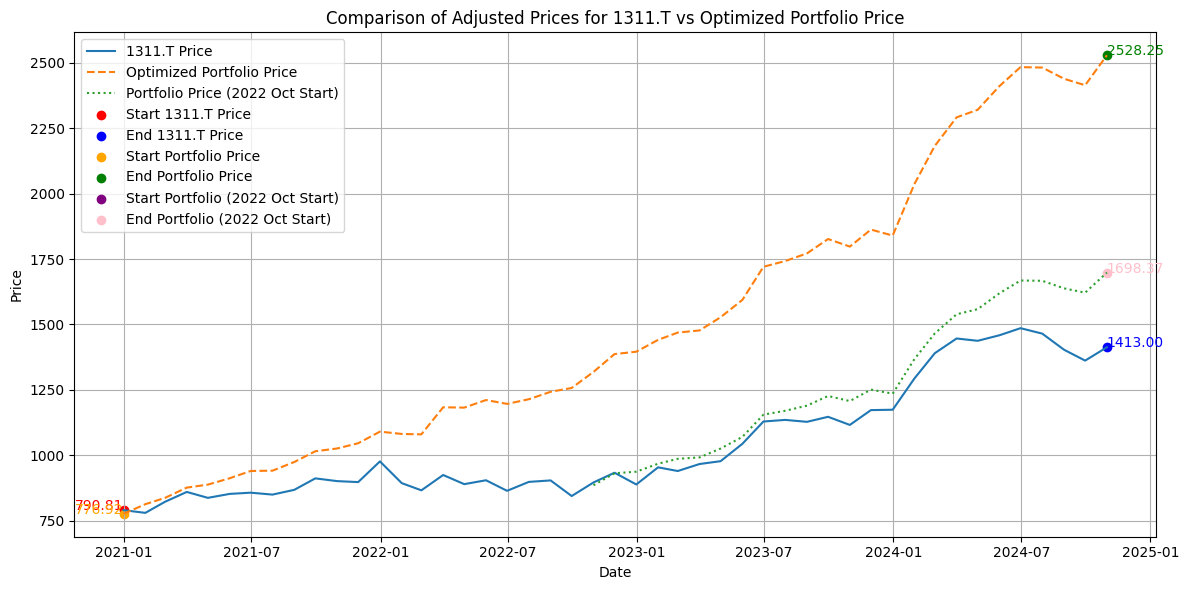

In [67]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define parameters
ticker_to_compare = "1311.T"
start_date = "2020-10-31"
end_date = "2024-10-31"

# Fetch data for 1311.T using yfinance
print(f"Fetching daily price data for {ticker_to_compare}")
data = yf.download(ticker_to_compare, start=start_date, end=end_date, progress=False)

if not data.empty:
    # Flatten multi-level column index if necessary
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(1)

    # Reset the index and add company details
    data.reset_index(inplace=True)
    data['Company Name'] = "1311.T Company"  # Placeholder name
    data['Ticker Symbol (JP)'] = ticker_to_compare

    # Rename columns for clarity
    data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Company Name', 'Ticker Symbol (JP)']
else:
    raise ValueError(f"No price data available for {ticker_to_compare}")

# Prepare the adjusted price DataFrame
actual_prices = data[['Date', 'Adj Close']].rename(columns={'Adj Close': '1311.T Price'})

# Ensure dates are timezone-naive
actual_prices['Date'] = pd.to_datetime(actual_prices['Date']).dt.tz_localize(None)

# Extract monthly end prices (ME)
actual_prices = actual_prices.set_index('Date').resample('M').last().reset_index()

# Load portfolio returns and calculate portfolio price series
monthly_returns = pd.read_csv('/content/monthly_returns_ME.csv', index_col=0, parse_dates=True)
optimized_weights_df = pd.read_csv('/content/topix_30_optimized_weights.csv', index_col=0, parse_dates=True)

# Divide portfolio returns by 100 (assuming they are in %)
portfolio_returns = (optimized_weights_df * monthly_returns).sum(axis=1) / 100

# Ensure portfolio return dates are timezone-naive
portfolio_returns.index = portfolio_returns.index.tz_localize(None)

# Get initial prices dynamically from 1311.T adjusted prices
start_new_portfolio = pd.to_datetime("2022-10-31")  # Convert to datetime
initial_price_main = actual_prices.loc[actual_prices['Date'] >= pd.to_datetime(start_date), '1311.T Price'].iloc[0]
initial_price_new = actual_prices.loc[actual_prices['Date'] >= start_new_portfolio, '1311.T Price'].iloc[0]

# Align the new portfolio price with 1311.T price on September 2022
price_sept_2022 = actual_prices.loc[actual_prices['Date'] == pd.to_datetime("2022-09-30"), '1311.T Price'].iloc[0]
filtered_returns = portfolio_returns[portfolio_returns.index >= start_new_portfolio]
portfolio_prices_new = (1 + filtered_returns).cumprod() * price_sept_2022
portfolio_prices_new_df = portfolio_prices_new.reset_index()
portfolio_prices_new_df.columns = ['Date', 'Portfolio Price (2022 Oct Start)']

# Convert portfolio returns into portfolio price series
portfolio_prices = (1 + portfolio_returns).cumprod() * initial_price_main
portfolio_prices_df = portfolio_prices.reset_index()
portfolio_prices_df.columns = ['Date', 'Portfolio Price']

# Merge actual prices of 1311.T with both portfolio price series
comparison_prices_df = pd.merge(actual_prices, portfolio_prices_df, on='Date', how='inner')
comparison_prices_df = pd.merge(comparison_prices_df, portfolio_prices_new_df, on='Date', how='left')

# Plot the comparison
plt.figure(figsize=(12, 6))
plt.plot(comparison_prices_df['Date'], comparison_prices_df['1311.T Price'], label='1311.T Price')
plt.plot(comparison_prices_df['Date'], comparison_prices_df['Portfolio Price'], label='Optimized Portfolio Price', linestyle='--')
plt.plot(comparison_prices_df['Date'], comparison_prices_df['Portfolio Price (2022 Oct Start)'], label='Portfolio Price (2022 Oct Start)', linestyle=':')

# Add data points and labels for the beginning and ending points
start_date_main = comparison_prices_df['Date'].iloc[0]
end_date_main = comparison_prices_df['Date'].iloc[-1]
start_price_1311 = comparison_prices_df['1311.T Price'].iloc[0]
end_price_1311 = comparison_prices_df['1311.T Price'].iloc[-1]

start_price_portfolio = comparison_prices_df['Portfolio Price'].iloc[0]
end_price_portfolio = comparison_prices_df['Portfolio Price'].iloc[-1]

start_price_portfolio_new = comparison_prices_df['Portfolio Price (2022 Oct Start)'].iloc[0]
end_price_portfolio_new = comparison_prices_df['Portfolio Price (2022 Oct Start)'].iloc[-1]

# Plot data points
plt.scatter(start_date_main, start_price_1311, color='red', label='Start 1311.T Price')
plt.scatter(end_date_main, end_price_1311, color='blue', label='End 1311.T Price')

plt.scatter(start_date_main, start_price_portfolio, color='orange', label='Start Portfolio Price')
plt.scatter(end_date_main, end_price_portfolio, color='green', label='End Portfolio Price')

plt.scatter(start_new_portfolio, start_price_portfolio_new, color='purple', label='Start Portfolio (2022 Oct Start)')
plt.scatter(end_date_main, end_price_portfolio_new, color='pink', label='End Portfolio (2022 Oct Start)')

# Add data labels
plt.text(start_date_main, start_price_1311, f"{start_price_1311:.2f}", color='red', fontsize=10, ha='right')
plt.text(end_date_main, end_price_1311, f"{end_price_1311:.2f}", color='blue', fontsize=10, ha='left')

plt.text(start_date_main, start_price_portfolio, f"{start_price_portfolio:.2f}", color='orange', fontsize=10, ha='right')
plt.text(end_date_main, end_price_portfolio, f"{end_price_portfolio:.2f}", color='green', fontsize=10, ha='left')

plt.text(start_new_portfolio, start_price_portfolio_new, f"{start_price_portfolio_new:.2f}", color='purple', fontsize=10, ha='right')
plt.text(end_date_main, end_price_portfolio_new, f"{end_price_portfolio_new:.2f}", color='pink', fontsize=10, ha='left')

# Set titles and labels
plt.title(f"Comparison of Adjusted Prices for {ticker_to_compare} vs Optimized Portfolio Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


All stocks

In [68]:
# Plot Pie Chart for Optimized Weights Evolution (all stocks)
plot_optimized_weight_evolution_with_slider(optimized_weights_df)

Stock with weight greater than 0.01

In [69]:
# Plot Pie Chart for Optimized Weights Evolution (Stock with weight greater than 0.01)
optimized_weights_df_drop1st = optimized_weights_df.iloc[1:, ]
plot_optimized_weight_evolution_with_slider_Top10(optimized_weights_df_drop1st)

Correlation Matrix of all 30 stocks

Top 5 Most Correlated Stocks:
                                     Most Correlated  Correlation Value (Most)
0  Mizuho Financial Group,Inc. - Mitsubishi Ufj F...                  0.846027
1  Mitsubishi Ufj Financial Group,Inc. - Mizuho F...                  0.846027
2  Sumitomo Mitsui Financial Group,Inc. - Mizuho ...                  0.835411
3  Mizuho Financial Group,Inc. - Sumitomo Mitsui ...                  0.835411
4  Mitsubishi Ufj Financial Group,Inc. - Sumitomo...                  0.818596
5  Sumitomo Mitsui Financial Group,Inc. - Mitsubi...                  0.818596
6         Mitsubishi Corporation - Mitsui & Co.,Ltd.                  0.797739
7         Mitsui & Co.,Ltd. - Mitsubishi Corporation                  0.797739
8           Smc Corporation - Tokyo Electron Limited                  0.736297
9           Tokyo Electron Limited - Smc Corporation                  0.736297

Top 5 Least Correlated Stocks:
                                    Least Correlated  \
0  Nippon Tel

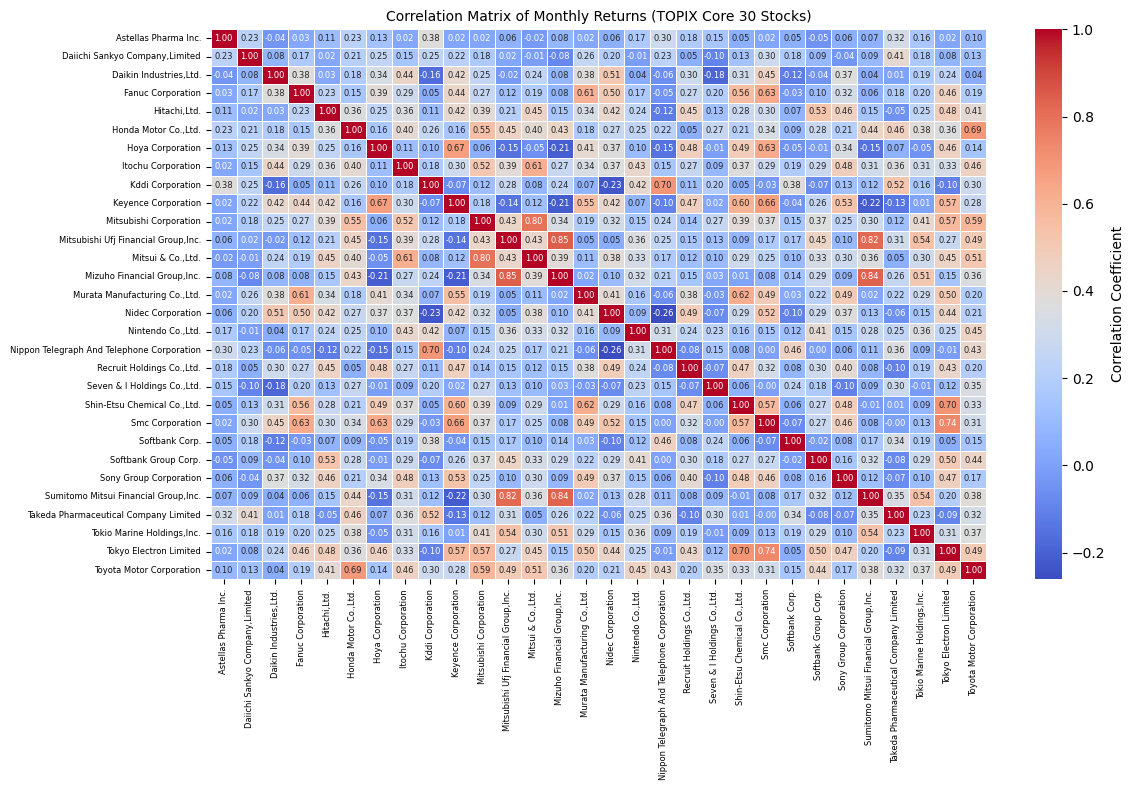

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = monthly_returns.corr()

# Find the most correlated pairs (top 5)
most_correlated = correlation_matrix.unstack().sort_values(ascending=False)
most_correlated = most_correlated[most_correlated < 1].head(10)  # Exclude self-correlation (1.0)

# Find the least correlated pairs (bottom 5)
least_correlated = correlation_matrix.unstack().sort_values().head(10)

# Create a DataFrame to display the results
correlation_summary = pd.DataFrame({
    'Most Correlated': most_correlated.index.map(lambda x: f"{x[0]} - {x[1]}"),
    'Correlation Value (Most)': most_correlated.values,
    'Least Correlated': least_correlated.index.map(lambda x: f"{x[0]} - {x[1]}"),
    'Correlation Value (Least)': least_correlated.values
})

# Display correlation summary
print("Top 5 Most Correlated Stocks:")
print(correlation_summary[['Most Correlated', 'Correlation Value (Most)']])
print("\nTop 5 Least Correlated Stocks:")
print(correlation_summary[['Least Correlated', 'Correlation Value (Least)']])

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'},
    annot_kws={"size": 6}  # Smaller annotation font size
)
plt.title("Correlation Matrix of Monthly Returns (TOPIX Core 30 Stocks)", fontsize=10)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()


## VAR

                                       Company       VaR
20                      Tokyo Electron Limited -0.040545
29                        Softbank Group Corp. -0.039286
5                    Recruit Holdings Co.,Ltd. -0.033973
16                            Hoya Corporation -0.032915
4               Daiichi Sankyo Company,Limited -0.032472
7                       Daikin Industries,Ltd. -0.032019
9                            Nidec Corporation -0.031699
8                                 Hitachi,Ltd. -0.030073
6                              Smc Corporation -0.030063
11                         Keyence Corporation -0.029884
12                           Fanuc Corporation -0.029476
14                    Toyota Motor Corporation -0.028961
19                           Mitsui & Co.,Ltd. -0.028648
15                        Honda Motor Co.,Ltd. -0.028035
13               Murata Manufacturing Co.,Ltd. -0.027912
1                  Shin-Etsu Chemical Co.,Ltd. -0.027804
10                      Sony Gr

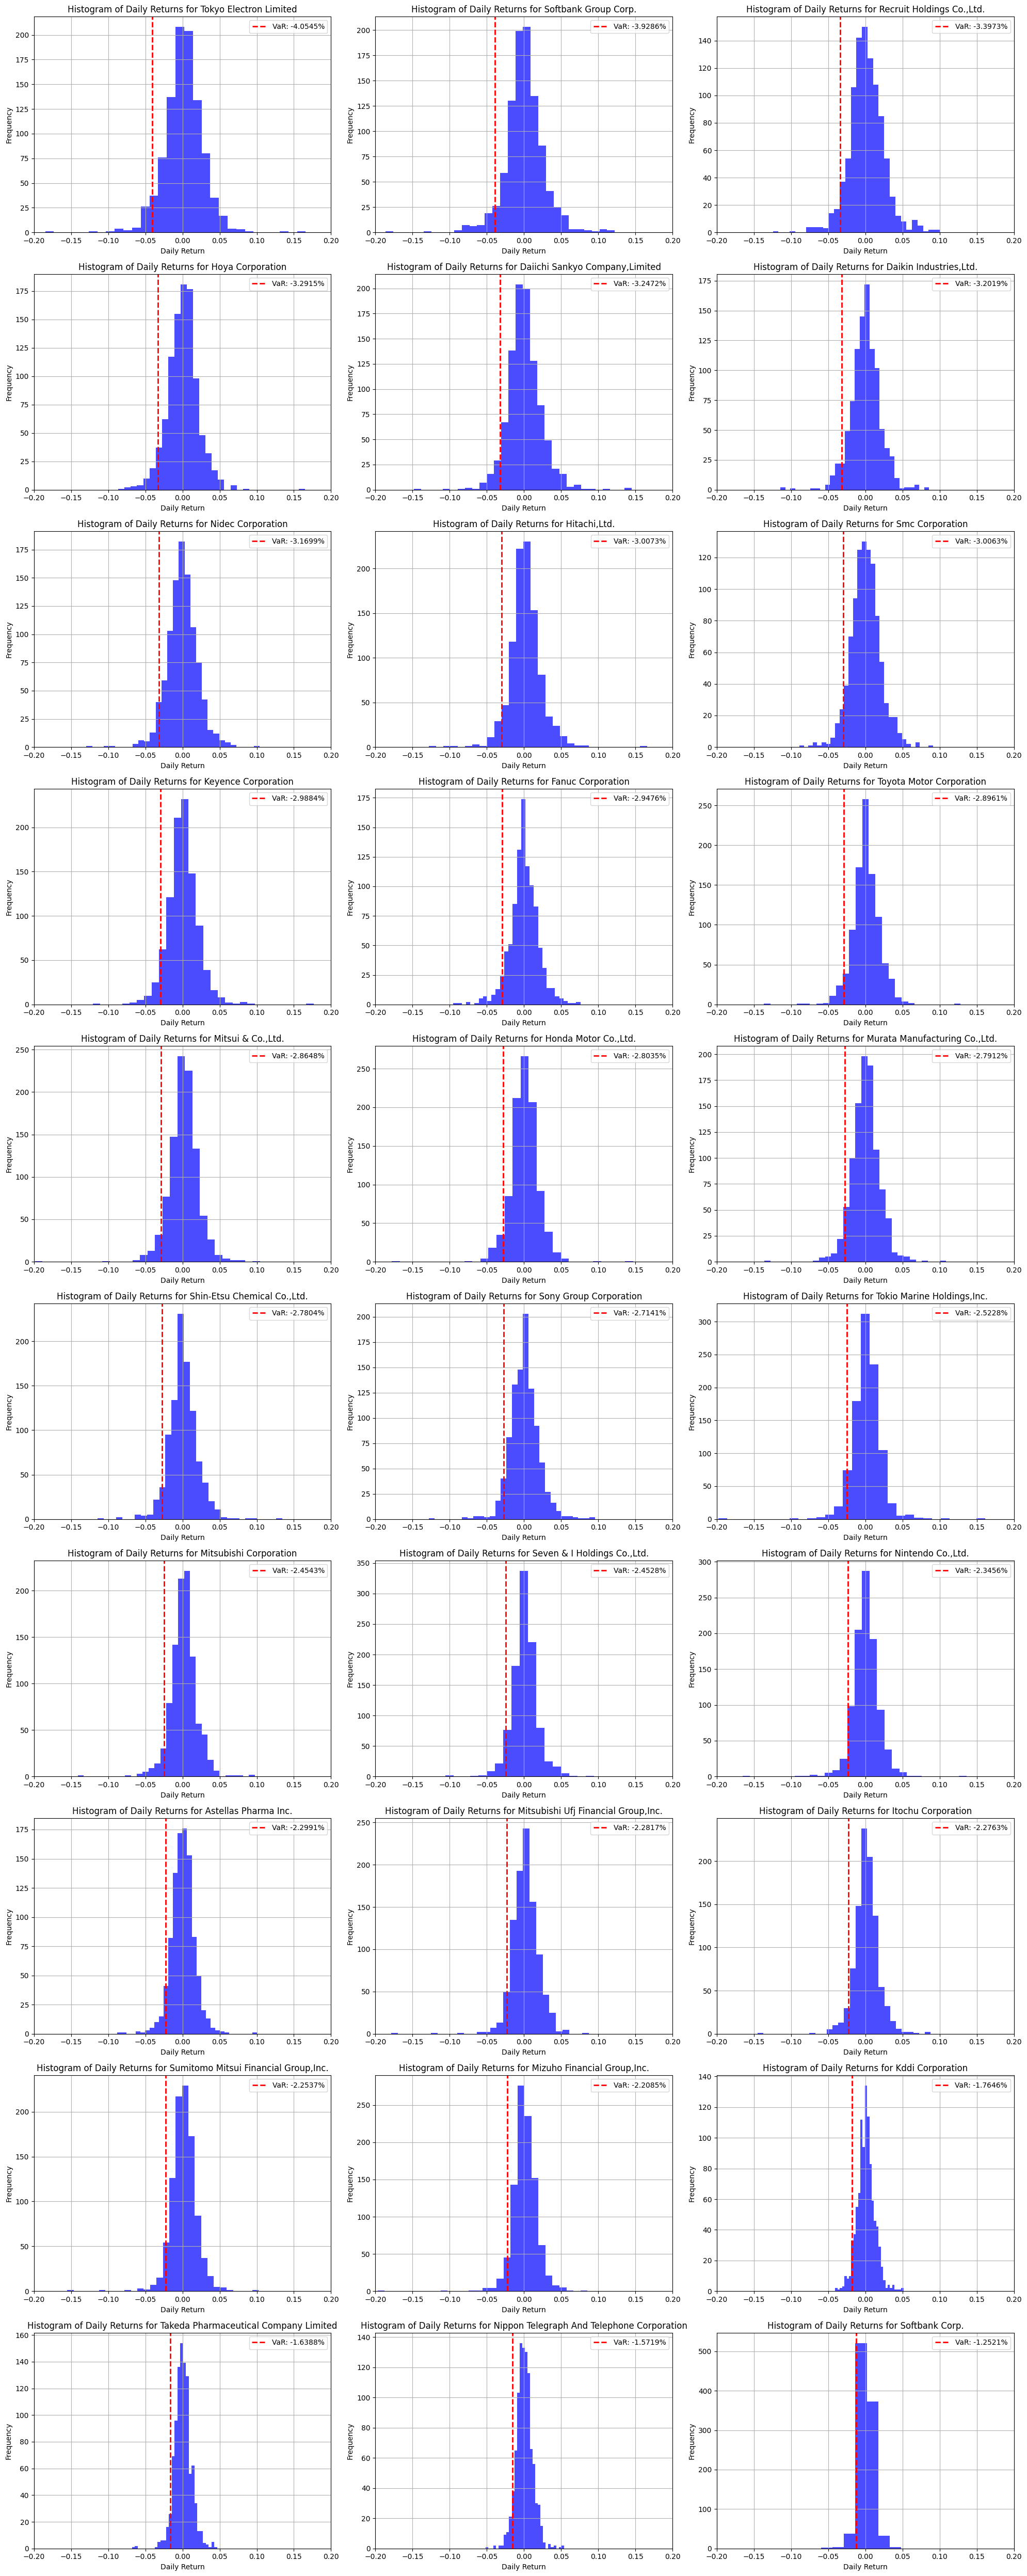

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('/content/topix_30_combined_daily_prices.csv')

# Get a list of unique companies
companies = data['Company Name'].unique()

# Set the confidence level for VaR
confidence_level = 0.95

# Initialize a list to store company VaR values
var_results = []

# Loop through each company
for company in companies:
    # Filter data for the current company and make a copy to avoid SettingWithCopyWarning
    company_data = data[data['Company Name'] == company].copy()

    # Calculate daily returns
    company_data['Daily Return'] = company_data['Adj Close'].pct_change()

    # Calculate VaR
    var_value = np.percentile(company_data['Daily Return'].dropna(), (1 - confidence_level) * 100)

    # Store the result
    var_results.append({'Company': company, 'VaR': var_value})

# Convert results to DataFrame
var_df = pd.DataFrame(var_results)

# Sort the DataFrame by VaR in descending order
var_df = var_df.sort_values(by='VaR', ascending=True)

# Print the sorted results
print(var_df)

# ---------------------------------------------
# Plot Histograms for Each Company (Optional)
# ---------------------------------------------

# Create a figure and axes for subplots
num_companies = len(companies)
cols = 3  # Number of columns in the subplot
rows = (num_companies + cols - 1) // cols  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for idx, company in enumerate(var_df['Company']):  # Use sorted company names
    # Filter data for the current company and make a copy
    company_data = data[data['Company Name'] == company].copy()

    # Calculate daily returns
    company_data['Daily Return'] = company_data['Adj Close'].pct_change()

    # Calculate VaR
    var_value = np.percentile(company_data['Daily Return'].dropna(), (1 - confidence_level) * 100)

    # Plot the histogram
    axes[idx].hist(company_data['Daily Return'].dropna(), bins=30, alpha=0.7, color='blue')
    axes[idx].set_title(f'Histogram of Daily Returns for {company}')
    axes[idx].set_xlabel('Daily Return')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid()
    axes[idx].axvline(x=var_value, color='red', linestyle='dashed', linewidth=2, label=f'VaR: {var_value:.4%}')
    axes[idx].legend()
    axes[idx].set_xlim((-0.2,0.2))

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


## **Sharpe Ratio**

daily sharpe ratio

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('/content/topix_30_combined_daily_prices.csv')

# Get a list of unique companies
companies = data['Company Name'].unique()
sr_results = []
risk_free_rate = 0.01

# Loop through each company
for company in companies:
    # Filter data for the current company and make a copy to avoid SettingWithCopyWarning
    company_data = data[data['Company Name'] == company].copy()

    # Calculate daily returns
    company_data['Daily Return'] = company_data['Adj Close'].pct_change()

    company_data = company_data.dropna()

    # Calculate ann_vol and ann_ret
    n_date = len(company_data['Daily Return'])
    ann_ret = (company_data['Daily Return']+1).prod()**(252/n_date) - 1
    ann_vol = company_data['Daily Return'].std()*np.sqrt(252)

    # Calculate Sharp ratio
    sr = (ann_ret - risk_free_rate) / ann_vol

    # Store the result
    sr_results.append({'Company': company, 'Sharp Ratio': sr, 'Annalize Return': ann_ret,  'Annalize Volatility': ann_vol})

# Convert results to DataFrame
sr_df = pd.DataFrame(sr_results)

# Sort the DataFrame by VaR in descending order
sr_df = sr_df.sort_values(by='Sharp Ratio', ascending=True)

# Print the sorted results. first 10 and last 10
print(sr_df.head(10))
print(sr_df.tail(10))

                           Company  Sharp Ratio  Annalize Return  \
9                Nidec Corporation    -0.357501        -0.106488   
7           Daikin Industries,Ltd.    -0.051040        -0.006207   
12               Fanuc Corporation    -0.027473         0.001668   
6                  Smc Corporation     0.153925         0.058128   
13   Murata Manufacturing Co.,Ltd.     0.155903         0.056421   
29            Softbank Group Corp.     0.221538         0.103162   
11             Keyence Corporation     0.282430         0.102566   
3             Astellas Pharma Inc.     0.326657         0.090791   
17               Nintendo Co.,Ltd.     0.413876         0.126643   
4   Daiichi Sankyo Company,Limited     0.422522         0.167315   

    Annalize Volatility  
9              0.325841  
7              0.317539  
12             0.303268  
6              0.312674  
13             0.297757  
29             0.420525  
11             0.327749  
3              0.247328  
17             0.

bottom 3 daily sharpe ratio

In [73]:
sr_df.head(3)

Company  Sharp Ratio  Annalize Return  Annalize Volatility
9        Nidec Corporation    -0.357501        -0.106488             0.325841
7   Daikin Industries,Ltd.    -0.051040        -0.006207             0.317539
12       Fanuc Corporation    -0.027473         0.001668             0.303268

top 3 daily sharpe ratio

In [74]:
sr_df.tail(3)

Company  Sharp Ratio  Annalize Return  \
22   Mitsubishi Ufj Financial Group,Inc.     1.593442         0.471354   
23  Sumitomo Mitsui Financial Group,Inc.     1.707920         0.474367   
8                           Hitachi,Ltd.     1.782727         0.608992   

    Annalize Volatility  
22             0.289533  
23             0.271890  
8              0.335998

monthly sharpe ratio

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
data_ME = pd.read_csv('/content/topix_30_combined_daily_prices.csv', index_col = 0, parse_dates = [0])
data_ME.index = pd.to_datetime(data_ME.index, format="%d/%m/%Y")
data_ME = data_ME.resample('ME').last()

# Get a list of unique companies
companies = data_ME['Company Name'].unique()
sr_me_results = []
risk_free_rate = 0.01

# Loop through each company
for company in companies:
    # Filter data for the current company and make a copy to avoid SettingWithCopyWarning
    company_data = data_ME[data_ME['Company Name'] == company].copy()

    # Calculate daily returns
    company_data['Monthy Return'] = company_data['Adj Close'].pct_change()

    company_data = company_data.dropna()

    # Calculate ann_vol and ann_ret
    n_months = len(company_data['Monthy Return'])
    ann_ret = (company_data['Monthy Return']+1).prod()**(12/n_months) - 1
    ann_vol = company_data['Monthy Return'].std()*np.sqrt(12)

    # Calculate Sharp ratio
    sr = (ann_ret - risk_free_rate) / ann_vol

    # Store the result
    sr_me_results.append({'Company': company, 'Sharp Ratio': sr, 'Annalize Return': ann_ret,  'Annalize Volatility': ann_vol})

# Convert results to DataFrame
sr_me_df = pd.DataFrame(sr_results)

# Sort the DataFrame by VaR in descending order
sr_me_df = sr_me_df.sort_values(by='Sharp Ratio', ascending=False)

# Print the sorted results. first 10 and last 10
print(sr_me_df.head(10))

                                       Company  Sharp Ratio  Annalize Return  \
8                                 Hitachi,Ltd.     1.782727         0.608992   
23        Sumitomo Mitsui Financial Group,Inc.     1.707920         0.474367   
22         Mitsubishi Ufj Financial Group,Inc.     1.593442         0.471354   
28                              Softbank Corp.     1.564500         0.624968   
21                      Mitsubishi Corporation     1.540621         0.442216   
19                           Mitsui & Co.,Ltd.     1.421978         0.461467   
18                          Itochu Corporation     1.387653         0.372276   
25                  Tokio Marine Holdings,Inc.     1.348265         0.432474   
24                 Mizuho Financial Group,Inc.     1.148163         0.317302   
26  Nippon Telegraph And Telephone Corporation     0.917617         0.172874   

    Annalize Volatility  
8              0.335998  
23             0.271890  
22             0.289533  
28             

## **Risk Parity**

In [76]:
def risk_parity_objective(weights, cov_matrix):
    risk_contribs = risk_contribution(weights, cov_matrix)
    mean_risk_contrib = np.mean(risk_contribs) # average risk contribution
    sum_sq_diff = np.sum(np.square(risk_contribs - mean_risk_contrib)) # sum of squared differences between each asset's risk contribution and the mean risk contribution
    return sum_sq_diff

def risk_contribution(weights, cov_matrix):
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) # variance -> standard deviation
    marginal_contrib = np.dot(cov_matrix, weights) # a vector where each element represents the contribution of each asset to the overall risk based on its weight
    risk_contrib = np.multiply(marginal_contrib, weights) / portfolio_vol # normalizes the contributions to reflect how much risk each asset contributes relative to the total portfolio risk
    print(risk_contrib)
    return risk_contrib

def min_risk_parity(risk_free_rate, returns, cov_matrix, bound):

    n_assets = returns.shape[0]
    init_weights = np.ones(n_assets) / n_assets # equal weight for each asset, first guess

    # Constraints
    bounds = tuple(bound for _ in range(n_assets)) # set bound of weight for each asset
    print(bounds)
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1} # constraint

    # Optimize
    # By minimizing this sum of squared differences, the optimization process seeks to adjust the weights of the assets such that:
    # The risk contributions are as close as possible to each other.
    # This leads to a more balanced risk distribution across the portfolio.
    # The main objective aligns with the concept of risk parity,
    # where the goal is to ensure that each asset contributes equally to the risk of the overall portfolio.
    # This strategy can enhance diversification and reduce exposure to any single asset's risk.

    result = minimize(risk_parity_objective, init_weights,
                    args=(cov_matrix,),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'ftol': 1e-12, 'maxiter': 1000})

    return result.x

In [77]:
def min_volatility(risk_free_rate, returns, cov_matrix, bound):

    n_assets = returns.shape[0]
    init_weights = np.ones(n_assets) / n_assets

    # Constraints
    bounds = tuple(bound for _ in range(n_assets)) # each asset
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    # portfolio_vol: vol = weights.T @ covmat @ weights, return vol ** 0.5
    weights = minimize(portfolio_vol, init_weights,
                        args=(cov_matrix,), method='SLSQP',
                        options={'disp': False},
                        constraints=constraints,
                        bounds=bounds)

    return weights.x

def maximize_return(target_vol, ret, cov, bound=(0.008, 0.1)):
    """Finds the weights that minimize volatility for a target return."""
    n = ret.shape[0]
    init_guess = np.repeat(1 / n, n)
    bounds = (bound,) * n

    weights_sum_to_1 = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1} # constraint: the total weight must equal 1

    volatility_is_target = {'type': 'eq', 'args': (ret,),
                        'fun': lambda weights, ret: target_vol - portfolio_vol(weights, cov)} # "eq", equality constraint, "args", Additional arguments to pass to the function
                        # constraint: target_vol−portfolio_vol(weights, cov)= 0, portfolio_vol: vol = weights.T @ covmat @ weights, return vol ** 0.5

    def neg_portfolio_return(weights, ret):
        return -1. * portfolio_return(weights, ret) # weights.T @ returns

    weights = minimize(neg_portfolio_return, init_guess, args=(ret,), method='SLSQP',
                       options={'disp': False}, constraints=(weights_sum_to_1, volatility_is_target),
                       bounds=bounds)
                        # find the optimal weight to maximize the return while ensuring the sum of weights is 1 and the volatility is the target value
    return weights.x

In [78]:
import datetime as dt

analysis_start = dt.datetime(2022,10,31)
analysis_months = pd.date_range(start=analysis_start, end=end_date, freq='M')
analysis_months

<ipython-input-78-691f27585f43>:4: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



DatetimeIndex(['2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31',
               '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
               '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30',
               '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31',
               '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31',
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31'],
              dtype='datetime64[ns]', freq='ME')

Topix Bound (0.008, 0.1)

In [79]:
opt_rets_tb = []
opt_vol_rets_tb = []
opt_risky_rets_tb = []

opt_weights_list_tb = []
opt_vol_weights_list_tb = []
opt_risky_weights_list_tb = []
months_index_tb = []

risk_free_rate = 0.01
bound = (0.008, 0.1)
for i_date, date in enumerate(analysis_months): # loop through every months
    # Slice the returns data up to the current date
    historical_returns = monthly_returns.loc[:date]

    # Calculate the covariance matrix for the historical returns
    cov_matrix = historical_returns.cov()

    # Calculate expected returns by annualizing the historical returns. annualize_rets: compounded_growth = (1 + ret).prod(), n_periods = ret.shape[0], return compounded_growth ** (periods_per_year / n_periods) - 1
    expected_returns = annualize_rets(historical_returns)

    # Calculate optimized weights (minize risk_parity)
    w_vol = min_volatility(risk_free_rate, expected_returns, cov_matrix, bound) # Finds the portfolio weights that minimize the volatility
    w_msr = msr(risk_free_rate, expected_returns, cov_matrix, bound) # Finds the portfolio weights that maximize the Sharpe Ratio.

    w_risky = min_risk_parity(risk_free_rate, expected_returns, cov_matrix, bound) # find a more balanced risk distribution across the portfolio
    vol_risky_parity = portfolio_vol(w_risky, cov_matrix) # Calculates portfolio volatility given weights and covariance matrix, vol = weights.T @ covmat @ weights, return vol ** 0.5 #
    w_risky_parity_max_ret = maximize_return(vol_risky_parity, expected_returns, cov_matrix, bound) # find the optimal weight to maximize the return while ensuring the sum of weights is 1 and the volatility is the target value


    if i_date + 1 == len(analysis_months):
        break
    next_date = analysis_months[i_date+1]
    if next_date in monthly_returns.index:
        opt_ret = portfolio_return(w_msr, monthly_returns.loc[next_date]) # calculate the return with the weights that maximize the Sharpe ratio, loc() slices a data set.
        opt_vol_ret = portfolio_return(w_vol, monthly_returns.loc[next_date]) # calculate the return with the weights that minimize the volatility
        opt_risky_ret = portfolio_return(w_risky_parity_max_ret, monthly_returns.loc[next_date]) # calculate the return with the set of well-balanced weights

        opt_rets_tb.append(opt_ret)
        opt_vol_rets_tb.append(opt_vol_ret)
        opt_risky_rets_tb.append(opt_risky_ret)

        opt_weights_list_tb.append(w_msr)
        opt_vol_weights_list_tb.append(w_vol)
        opt_risky_weights_list_tb.append(w_risky_parity_max_ret)

        months_index_tb.append(next_date)

Streaming output truncated to the last 5000 lines.
[0.00110962 0.00109573 0.0010849  0.00106468 0.00109401 0.00107452
 0.00108223 0.00110894 0.00114169 0.0011111  0.00108247 0.00104332
 0.00109014 0.00108555 0.00109575 0.00110537 0.0011214  0.00097494
 0.00109745 0.00111964 0.00110441 0.00108519 0.00113345 0.00108136
 0.00111386 0.00110588 0.00112441 0.00111178 0.00109208 0.00110932]
[0.00110962 0.00109573 0.0010849  0.00106468 0.00109401 0.00107452
 0.00108223 0.00110894 0.00114169 0.0011111  0.00108247 0.00104332
 0.00109014 0.00108555 0.00109575 0.00110537 0.0011214  0.00097494
 0.00109745 0.00111964 0.00110441 0.00108519 0.00113345 0.00108136
 0.00111386 0.00110588 0.00112441 0.00111178 0.00109208 0.00110932]
[0.00110962 0.00109573 0.0010849  0.00106468 0.00109401 0.00107452
 0.00108223 0.00110894 0.00114169 0.0011111  0.00108247 0.00104332
 0.00109014 0.00108555 0.00109575 0.00110537 0.0011214  0.00097494
 0.00109745 0.00111964 0.00110441 0.00108519 0.00113345 0.00108136
 0.001113

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



Streaming output truncated to the last 5000 lines.
[0.00108658 0.00107989 0.00108166 0.00106742 0.00107416 0.00107963
 0.00107516 0.00108229 0.0011077  0.00108441 0.00107163 0.00109017
 0.00107883 0.00107462 0.00108975 0.00108284 0.00105541 0.00102473
 0.00109729 0.00108317 0.00107425 0.0010887  0.00107217 0.0010753
 0.00108551 0.00106595 0.00109606 0.00107179 0.00107715 0.00104806]
[0.00108658 0.00107989 0.00108166 0.00106742 0.00107416 0.00107963
 0.00107516 0.00108229 0.0011077  0.00108441 0.00107163 0.00109017
 0.00107883 0.00107462 0.00108975 0.00108284 0.00105541 0.00102473
 0.00109729 0.00108317 0.00107425 0.0010887  0.00107217 0.0010753
 0.00108551 0.00106595 0.00109606 0.00107179 0.00107715 0.00104806]
[0.00108658 0.00107989 0.00108166 0.00106742 0.00107416 0.00107963
 0.00107516 0.00108229 0.0011077  0.00108441 0.00107163 0.00109017
 0.00107883 0.00107462 0.00108975 0.00108284 0.00105541 0.00102473
 0.00109729 0.00108317 0.00107425 0.0010887  0.00107217 0.0010753
 0.00108551 

Topix Bound (0, 1)

In [80]:
opt_rets = []
opt_vol_rets = []
opt_risky_rets = []
months_index = []
opt_weights_list = []
opt_vol_weights_list = []
opt_risky_weights_list = []

risk_free_rate = 0.01
bound = (0, 1)
for i_date, date in enumerate(analysis_months):
    # Slice the returns data up to the current date
    historical_returns = monthly_returns.loc[:date]

    # Calculate the covariance matrix for the historical returns
    cov_matrix = historical_returns.cov()

    # Calculate expected returns by annualizing the historical returns. annualize_rets: compounded_growth = (1 + ret).prod(), n_periods = ret.shape[0], return compounded_growth ** (periods_per_year / n_periods) - 1
    expected_returns = annualize_rets(historical_returns)

    # Calculate optimized weights (minize risk_parity)
    w_vol = min_volatility(risk_free_rate, expected_returns, cov_matrix, bound)
    w_msr = msr(risk_free_rate, expected_returns, cov_matrix, bound)

    w_risky = min_risk_parity(risk_free_rate, expected_returns, cov_matrix, bound)
    vol_risky_parity = portfolio_vol(w_risky, cov_matrix)
    w_risky_parity_max_ret = maximize_return(vol_risky_parity, expected_returns, cov_matrix, bound)

    if i_date + 1 == len(analysis_months):
        break
    next_date = analysis_months[i_date+1]
    if next_date in monthly_returns.index:
        opt_ret = portfolio_return(w_msr, monthly_returns.loc[next_date])
        opt_vol_ret = portfolio_return(w_vol, monthly_returns.loc[next_date])
        opt_risky_ret = portfolio_return(w_risky_parity_max_ret, monthly_returns.loc[next_date])

        opt_rets.append(opt_ret)
        opt_vol_rets.append(opt_vol_ret)
        opt_risky_rets.append(opt_risky_ret)

        opt_weights_list.append(w_msr)
        opt_vol_weights_list.append(w_vol)
        opt_risky_weights_list.append(w_risky_parity_max_ret)

        months_index.append(next_date)

Streaming output truncated to the last 5000 lines.
[0.0010866  0.00107983 0.00108152 0.00106739 0.00107427 0.00107953
 0.00107514 0.00108219 0.00110735 0.00108434 0.00107109 0.00109018
 0.00107874 0.00107457 0.00108962 0.00108275 0.00105566 0.00102507
 0.00109773 0.00108321 0.00107421 0.0010885  0.00107241 0.00107616
 0.00108545 0.00106609 0.00109577 0.00107189 0.00107636 0.00104846]
[0.0010866  0.00107983 0.00108152 0.00106739 0.00107427 0.00107953
 0.00107514 0.00108219 0.00110735 0.00108434 0.00107109 0.00109018
 0.00107874 0.00107457 0.00108962 0.00108275 0.00105566 0.00102507
 0.00109773 0.00108321 0.00107421 0.0010885  0.00107241 0.00107616
 0.00108545 0.00106609 0.00109577 0.00107189 0.00107636 0.00104846]
[0.0010866  0.00107983 0.00108152 0.00106739 0.00107427 0.00107953
 0.00107514 0.00108219 0.00110735 0.00108434 0.00107109 0.00109018
 0.00107874 0.00107457 0.00108962 0.00108275 0.00105566 0.00102507
 0.00109773 0.00108321 0.00107421 0.0010885  0.00107241 0.00107616
 0.001085

Tablize the monthly return

In [81]:
opt_monthlyend_returns = {"Returns": opt_rets, "Returns(MinVol)": opt_vol_rets, "Returns(MinRiskyParity)": opt_risky_rets,
                          "Returns-TopixBound": opt_rets_tb, "Returns(MinVol)-TopixBound": opt_vol_rets_tb, "Returns(MinRiskyParity)-TopixBound": opt_risky_rets_tb}
                          # variable with _tb: bounds(0.008,1)
                          # without: bounds(0,1)
df_opt_monthlyend_returns = pd.DataFrame(opt_monthlyend_returns, index=months_index)
df_opt_monthlyend_returns.head()

Returns  Returns(MinVol)  Returns(MinRiskyParity)  \
2022-11-30  0.008069        -0.006428                 0.008187   
2022-12-31 -0.026353        -0.037295                -0.025863   
2023-01-31  0.022386         0.058239                 0.027426   
2023-02-28  0.020812         0.015363                 0.020528   
2023-03-31 -0.008246        -0.019036                -0.008811   

            Returns-TopixBound  Returns(MinVol)-TopixBound  \
2022-11-30            0.051291                    0.024537   
2022-12-31           -0.017537                   -0.035263   
2023-01-31            0.029627                    0.046915   
2023-02-28            0.018061                    0.011005   
2023-03-31           -0.009197                    0.002357   

            Returns(MinRiskyParity)-TopixBound  
2022-11-30                            0.046862  
2022-12-31                           -0.026178  
2023-01-31                            0.035563  
2023-02-28                            0.014659  
2023-03-31                           -0.007676

In [82]:
df_opt_monthlyend_returns.to_csv('/content/topix_30_monthyend_opt_return.csv')

In [83]:
# save the opt weight for return
df_wmsr = pd.DataFrame(opt_weights_list, index=months_index, columns=monthly_returns.columns) # monthly weights that maximize the Sharpe ratio with bound (0,1)
df_wmsr.to_csv('topix_30_monthy_opt_ret_weight.csv')

# save the opt weight for return at topix bound
df_wmsr_tb = pd.DataFrame(opt_weights_list_tb, index=months_index_tb, columns=monthly_returns.columns) # monthly weights that maximize the Sharpe ratio with bound (0.008,1)
df_wmsr_tb.to_csv('topix_30_monthy_opt_ret_weight_topixbd.csv')

# save the opt risky partiy weight for return
df_risky = pd.DataFrame(opt_risky_weights_list, index=months_index, columns=monthly_returns.columns)
df_risky.to_csv('topix_30_monthy_opt_risky_ret_weight.csv')

# save the opt risky partiy weight for return at topix bound
df_risky_tb = pd.DataFrame(opt_risky_weights_list_tb, index=months_index, columns=monthly_returns.columns)
df_risky_tb.to_csv('topix_30_monthy_opt_risky_ret_weight_topixbd.csv')

# save the opt vol weight for return
df_vol = pd.DataFrame(opt_vol_weights_list, index=months_index, columns=monthly_returns.columns)
df_vol.to_csv('topix_30_monthy_opt_vol_ret_weight.csv')

# save the opt vol weight for return at topix bound
df_vol_tb = pd.DataFrame(opt_vol_weights_list_tb, index=months_index, columns=monthly_returns.columns)
df_vol_tb.to_csv('topix_30_monthy_opt_vol_ret_weight_topixbd.csv')

## Compare the return with the TOPIX30 return

In [84]:
topix30_daily_price = yf.download(['1311.T'], start=start_date, end=end_date, progress=False)['Adj Close']
topix30_daily_price.columns = ['TOPIX30']
topix30_daily_price.index = topix30_daily_price.index.strftime("%Y-%m-%d")
topix30_daily_price.index = pd.to_datetime(topix30_daily_price.index)
topix30_monthy_price = topix30_daily_price.resample('ME').last()
topix30_monthy_returns = topix30_monthy_price.pct_change().dropna()

df_opt_monthlyend_returns_with_topix30 = df_opt_monthlyend_returns.copy()
df_opt_monthlyend_returns_with_topix30['Return(TOPIX30)'] = topix30_monthy_returns[months_index[0]:months_index[-1]]

df_opt_monthlyend_returns_with_topix30.to_csv('/content/topix_30_monthyend_opt_return_with_topix30ret.csv')

<Axes: >

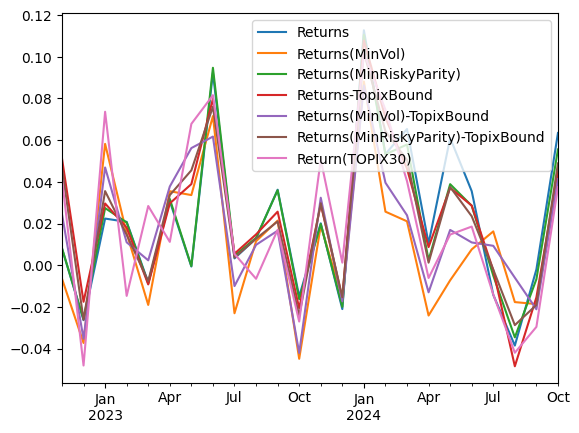

In [85]:
df_opt_monthlyend_returns_with_topix30.plot()

<Axes: ylabel='Returns'>

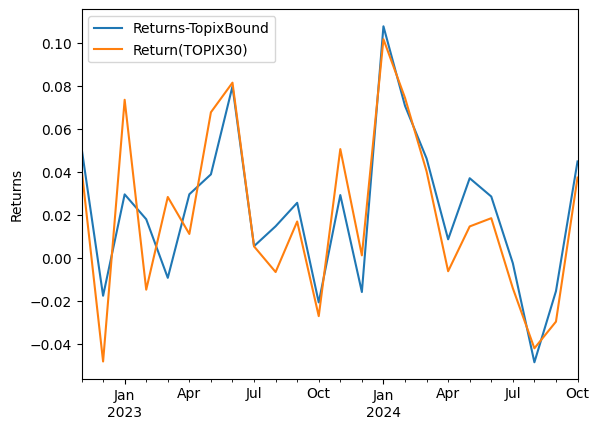

In [86]:
df_opt_monthlyend_returns_with_topix30['Returns-TopixBound'].plot(legend=True, ylabel='Returns')
df_opt_monthlyend_returns_with_topix30['Return(TOPIX30)'].plot(legend=True)

<Axes: ylabel='Returns'>

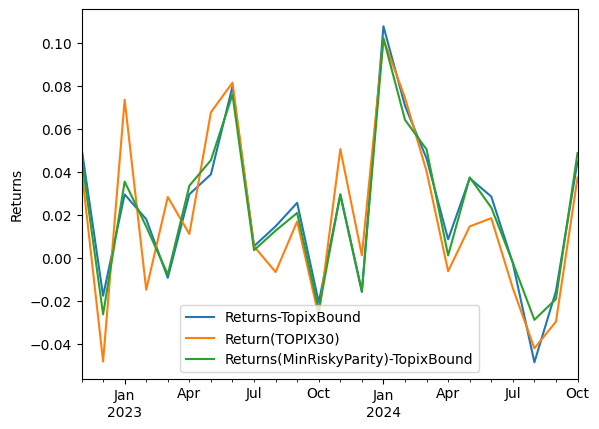

In [87]:
df_opt_monthlyend_returns_with_topix30['Returns-TopixBound'].plot(legend=True, ylabel='Returns')
df_opt_monthlyend_returns_with_topix30['Return(TOPIX30)'].plot(legend=True)
df_opt_monthlyend_returns_with_topix30['Returns(MinRiskyParity)-TopixBound'].plot(legend=True, ylabel='Returns')


<Axes: ylabel='Returns'>

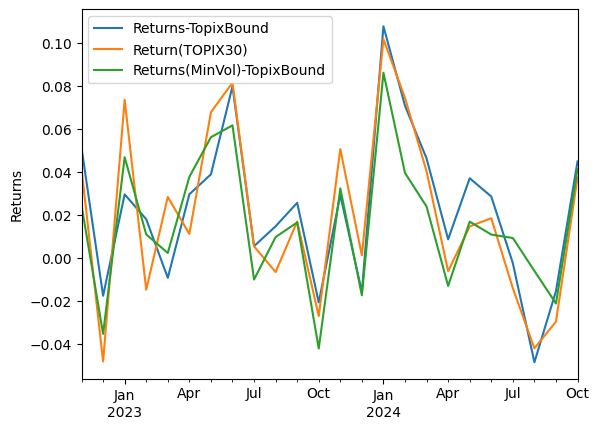

In [88]:
df_opt_monthlyend_returns_with_topix30['Returns-TopixBound'].plot(legend=True, ylabel='Returns')
df_opt_monthlyend_returns_with_topix30['Return(TOPIX30)'].plot(legend=True)
df_opt_monthlyend_returns_with_topix30['Returns(MinVol)-TopixBound'].plot(legend=True, ylabel='Returns')

<Axes: ylabel='Returns'>

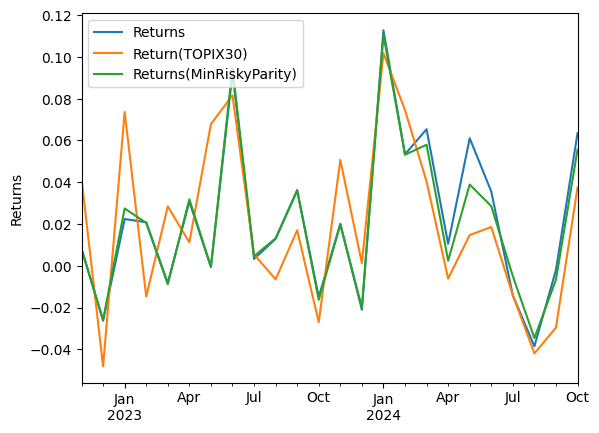

In [89]:
df_opt_monthlyend_returns_with_topix30['Returns'].plot(legend=True, ylabel='Returns')
df_opt_monthlyend_returns_with_topix30['Return(TOPIX30)'].plot(legend=True)
df_opt_monthlyend_returns_with_topix30['Returns(MinRiskyParity)'].plot(legend=True, ylabel='Returns')


<Axes: ylabel='Returns'>

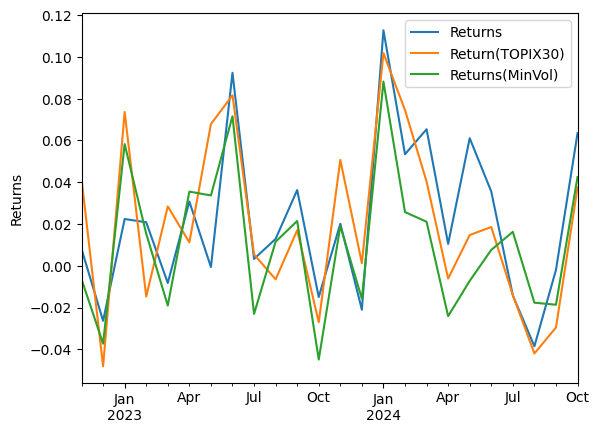

In [90]:
df_opt_monthlyend_returns_with_topix30['Returns'].plot(legend=True, ylabel='Returns')
df_opt_monthlyend_returns_with_topix30['Return(TOPIX30)'].plot(legend=True)
df_opt_monthlyend_returns_with_topix30['Returns(MinVol)'].plot(legend=True, ylabel='Returns')

Cumulative return comparison

In [91]:
(df_opt_monthlyend_returns_with_topix30 + 1).prod() - 1

Returns                               0.651531
Returns(MinVol)                       0.270430
Returns(MinRiskyParity)               0.594677
Returns-TopixBound                    0.678770
Returns(MinVol)-TopixBound            0.446296
Returns(MinRiskyParity)-TopixBound    0.658611
Return(TOPIX30)                       0.576034
dtype: float64

## **Compare the effective frontier**

In [92]:
last_date = monthly_returns.index[-1]

# Slice historical returns up to the last date
historical_returns = monthly_returns.loc[:last_date]

# Calculate the covariance matrix for the historical returns
cov_matrix = historical_returns.cov()

# Calculate expected returns by annualizing the historical returns
expected_returns = annualize_rets(historical_returns)

## Bound = (0.008, 0.1)

In [93]:
bound = (0.008, 0.1)

w_risky = min_risk_parity(risk_free_rate, expected_returns, cov_matrix, bound)
w_vol = min_volatility(risk_free_rate, expected_returns, cov_matrix, bound)
w_msr = msr(risk_free_rate, expected_returns, cov_matrix, bound)

risky_vol = portfolio_vol(w_risky, cov_matrix)
w_risky_vol_max_ret = maximize_return(risky_vol, expected_returns, cov_matrix, bound)

Streaming output truncated to the last 5000 lines.
[0.00108658 0.00107989 0.00108166 0.00106742 0.00107416 0.00107963
 0.00107516 0.00108229 0.0011077  0.00108441 0.00107163 0.00109017
 0.00107883 0.00107462 0.00108975 0.00108284 0.00105541 0.00102473
 0.00109729 0.00108317 0.00107425 0.0010887  0.00107217 0.0010753
 0.00108551 0.00106595 0.00109606 0.00107179 0.00107715 0.00104806]
[0.00108658 0.00107989 0.00108166 0.00106742 0.00107416 0.00107963
 0.00107516 0.00108229 0.0011077  0.00108441 0.00107163 0.00109017
 0.00107883 0.00107462 0.00108975 0.00108284 0.00105541 0.00102473
 0.00109729 0.00108317 0.00107425 0.0010887  0.00107217 0.0010753
 0.00108551 0.00106595 0.00109606 0.00107179 0.00107715 0.00104806]
[0.00108658 0.00107989 0.00108166 0.00106742 0.00107416 0.00107963
 0.00107516 0.00108229 0.0011077  0.00108441 0.00107163 0.00109017
 0.00107883 0.00107462 0.00108975 0.00108284 0.00105541 0.00102473
 0.00109729 0.00108317 0.00107425 0.0010887  0.00107217 0.0010753
 0.00108551 

Efficient Frontier

In [94]:
# Plot the Efficient Frontier with the CML
plot_efficient_frontier_with_cml(expected_returns, cov_matrix, bound=(0.008, 0.1), riskfree_rate=0.01, is_risky_parity=True, is_min_vol=True)

Streaming output truncated to the last 5000 lines.
[0.00108658 0.00107989 0.00108166 0.00106742 0.00107416 0.00107963
 0.00107516 0.00108229 0.0011077  0.00108441 0.00107163 0.00109017
 0.00107883 0.00107462 0.00108975 0.00108284 0.00105541 0.00102473
 0.00109729 0.00108317 0.00107425 0.0010887  0.00107217 0.0010753
 0.00108551 0.00106595 0.00109606 0.00107179 0.00107715 0.00104806]
[0.00108658 0.00107989 0.00108166 0.00106742 0.00107416 0.00107963
 0.00107516 0.00108229 0.0011077  0.00108441 0.00107163 0.00109017
 0.00107883 0.00107462 0.00108975 0.00108284 0.00105541 0.00102473
 0.00109729 0.00108317 0.00107425 0.0010887  0.00107217 0.0010753
 0.00108551 0.00106595 0.00109606 0.00107179 0.00107715 0.00104806]
[0.00108658 0.00107989 0.00108166 0.00106742 0.00107416 0.00107963
 0.00107516 0.00108229 0.0011077  0.00108441 0.00107163 0.00109017
 0.00107883 0.00107462 0.00108975 0.00108284 0.00105541 0.00102473
 0.00109729 0.00108317 0.00107425 0.0010887  0.00107217 0.0010753
 0.00108551 

weight distribute of maximun sharpe ratio

In [95]:
last_optimized_weights_df = pd.DataFrame(
    [w_msr],
    index=[last_date],
    columns=monthly_returns.columns
)

# Normalize weights to ensure they sum to 100% for visualization
last_optimized_weights_df = last_optimized_weights_df.div(last_optimized_weights_df.sum(axis=1), axis=0) * 100
plot_optimized_weight_evolution_with_slider_Top10(last_optimized_weights_df)

weight distribute of minimum risk parity with maximum return

In [96]:
last_optimized_weights_rvmr_df = pd.DataFrame(
    [w_risky_vol_max_ret],
    index=[last_date],
    columns=monthly_returns.columns
)

# Normalize weights to ensure they sum to 100% for visualization
last_optimized_weights_rvmr_df = last_optimized_weights_rvmr_df.div(last_optimized_weights_rvmr_df.sum(axis=1), axis=0) * 100
plot_optimized_weight_evolution_with_slider_Top10(last_optimized_weights_rvmr_df)

Weight vs Var vs Sharpe Ratio

In [97]:
weight_dict = {'Weight': w_msr, 'Company': monthly_returns.columns}
WeightVarSR_df = pd.DataFrame(weight_dict).sort_values(by=['Company'])
var_df_sort = var_df.sort_values(by=['Company'])
sr_df_sort = sr_df.sort_values(by=['Company'])
WeightVarSR_df['VaR'] = var_df_sort['VaR'].values
WeightVarSR_df['Sharp Ratio'] = sr_df_sort['Sharp Ratio'].values

WeightVarSR_df = WeightVarSR_df.sort_values(by=['Weight'], ascending=False)
WeightVarSR_df.head()

Weight                               Company       VaR  Sharp Ratio
12     0.1                     Mitsui & Co.,Ltd. -0.028648     1.421978
22     0.1                        Softbank Corp. -0.012521     1.564500
25     0.1  Sumitomo Mitsui Financial Group,Inc. -0.022537     1.707920
27     0.1            Tokio Marine Holdings,Inc. -0.025228     1.348265
19     0.1           Seven & I Holdings Co.,Ltd. -0.024528     0.741958

In [98]:
WeightVarSR_dfw = WeightVarSR_df[WeightVarSR_df['Weight'] > 0.005]
WeightVarSR_dfw[:min(10, len(WeightVarSR_dfw))]

Weight                                     Company       VaR  \
12  0.100000                           Mitsui & Co.,Ltd. -0.028648   
22  0.100000                              Softbank Corp. -0.012521   
25  0.100000        Sumitomo Mitsui Financial Group,Inc. -0.022537   
27  0.100000                  Tokio Marine Holdings,Inc. -0.025228   
19  0.100000                 Seven & I Holdings Co.,Ltd. -0.024528   
4   0.100000                                Hitachi,Ltd. -0.030073   
13  0.078631                 Mizuho Financial Group,Inc. -0.022085   
17  0.070007  Nippon Telegraph And Telephone Corporation -0.015719   
6   0.050258                            Hoya Corporation -0.032915   
7   0.025311                          Itochu Corporation -0.022763   

    Sharp Ratio  
12     1.421978  
22     1.564500  
25     1.707920  
27     1.348265  
19     0.741958  
4      1.782727  
13     1.148163  
17     0.917617  
6      0.424409  
7      1.387653

## Normal bound (0, 1)

In [99]:
bound = (0, 1)

w_risky = min_risk_parity(risk_free_rate, expected_returns, cov_matrix, bound)
w_vol = min_volatility(risk_free_rate, expected_returns, cov_matrix, bound)
w_msr = msr(risk_free_rate, expected_returns, cov_matrix, bound)

risky_vol = portfolio_vol(w_risky, cov_matrix)
w_risky_vol_max_ret = maximize_return(risky_vol, expected_returns, cov_matrix, bound)

Streaming output truncated to the last 5000 lines.
[0.0010866  0.00107983 0.00108152 0.00106739 0.00107427 0.00107953
 0.00107514 0.00108219 0.00110735 0.00108434 0.00107109 0.00109018
 0.00107874 0.00107457 0.00108962 0.00108275 0.00105566 0.00102507
 0.00109773 0.00108321 0.00107421 0.0010885  0.00107241 0.00107616
 0.00108545 0.00106609 0.00109577 0.00107189 0.00107636 0.00104846]
[0.0010866  0.00107983 0.00108152 0.00106739 0.00107427 0.00107953
 0.00107514 0.00108219 0.00110735 0.00108434 0.00107109 0.00109018
 0.00107874 0.00107457 0.00108962 0.00108275 0.00105566 0.00102507
 0.00109773 0.00108321 0.00107421 0.0010885  0.00107241 0.00107616
 0.00108545 0.00106609 0.00109577 0.00107189 0.00107636 0.00104846]
[0.0010866  0.00107983 0.00108152 0.00106739 0.00107427 0.00107953
 0.00107514 0.00108219 0.00110735 0.00108434 0.00107109 0.00109018
 0.00107874 0.00107457 0.00108962 0.00108275 0.00105566 0.00102507
 0.00109773 0.00108321 0.00107421 0.0010885  0.00107241 0.00107616
 0.001085

Efficient Frontier

In [100]:
# Plot the Efficient Frontier with the CML
plot_efficient_frontier_with_cml(expected_returns, cov_matrix, bound=(0, 1), riskfree_rate=0.01, is_risky_parity=True, is_min_vol=True)

Streaming output truncated to the last 5000 lines.
[0.0010866  0.00107983 0.00108152 0.00106739 0.00107427 0.00107953
 0.00107514 0.00108219 0.00110735 0.00108434 0.00107109 0.00109018
 0.00107874 0.00107457 0.00108962 0.00108275 0.00105566 0.00102507
 0.00109773 0.00108321 0.00107421 0.0010885  0.00107241 0.00107616
 0.00108545 0.00106609 0.00109577 0.00107189 0.00107636 0.00104846]
[0.0010866  0.00107983 0.00108152 0.00106739 0.00107427 0.00107953
 0.00107514 0.00108219 0.00110735 0.00108434 0.00107109 0.00109018
 0.00107874 0.00107457 0.00108962 0.00108275 0.00105566 0.00102507
 0.00109773 0.00108321 0.00107421 0.0010885  0.00107241 0.00107616
 0.00108545 0.00106609 0.00109577 0.00107189 0.00107636 0.00104846]
[0.0010866  0.00107983 0.00108152 0.00106739 0.00107427 0.00107953
 0.00107514 0.00108219 0.00110735 0.00108434 0.00107109 0.00109018
 0.00107874 0.00107457 0.00108962 0.00108275 0.00105566 0.00102507
 0.00109773 0.00108321 0.00107421 0.0010885  0.00107241 0.00107616
 0.001085

weight distribute of maximun sharpe ratio

In [101]:
last_optimized_weights_df = pd.DataFrame(
    [w_msr],
    index=[last_date],
    columns=monthly_returns.columns
)

# Normalize weights to ensure they sum to 100% for visualization
last_optimized_weights_df = last_optimized_weights_df.div(last_optimized_weights_df.sum(axis=1), axis=0) * 100
plot_optimized_weight_evolution_with_slider_Top10(last_optimized_weights_df)

weight distribute of minimum risk parity with maximum return

In [102]:
last_optimized_weights_rvmr_df = pd.DataFrame(
    [w_risky_vol_max_ret],
    index=[last_date],
    columns=monthly_returns.columns
)

# Normalize weights to ensure they sum to 100% for visualization
last_optimized_weights_rvmr_df = last_optimized_weights_rvmr_df.div(last_optimized_weights_rvmr_df.sum(axis=1), axis=0) * 100
plot_optimized_weight_evolution_with_slider_Top10(last_optimized_weights_rvmr_df)

Weight vs Var vs Sharpe ratio

In [103]:
weight_dict = {'Company': monthly_returns.columns, 'Weight': w_msr}
WeightVarSR_df = pd.DataFrame(weight_dict).sort_values(by=['Company'])
var_df_sort = var_df.sort_values(by=['Company'])
sr_df_sort = sr_df.sort_values(by=['Company'])
WeightVarSR_df['VaR'] = var_df_sort['VaR'].values
WeightVarSR_df['Sharp Ratio'] = sr_df_sort['Sharp Ratio'].values

WeightVarSR_df = WeightVarSR_df.sort_values(by=['Weight'], ascending=False)
WeightVarSR_df.head()

Company    Weight       VaR  \
4                                 Hitachi,Ltd.  0.366622 -0.030073   
25        Sumitomo Mitsui Financial Group,Inc.  0.221449 -0.022537   
17  Nippon Telegraph And Telephone Corporation  0.143813 -0.015719   
27                  Tokio Marine Holdings,Inc.  0.094666 -0.025228   
22                              Softbank Corp.  0.080192 -0.012521   

    Sharp Ratio  
4      1.782727  
25     1.707920  
17     0.917617  
27     1.348265  
22     1.564500

In [104]:
WeightVarSR_df[WeightVarSR_df['Weight'] > 0.005]

Company    Weight       VaR  \
4                                 Hitachi,Ltd.  0.366622 -0.030073   
25        Sumitomo Mitsui Financial Group,Inc.  0.221449 -0.022537   
17  Nippon Telegraph And Telephone Corporation  0.143813 -0.015719   
27                  Tokio Marine Holdings,Inc.  0.094666 -0.025228   
22                              Softbank Corp.  0.080192 -0.012521   
19                 Seven & I Holdings Co.,Ltd.  0.065481 -0.024528   
6                             Hoya Corporation  0.026738 -0.032915   

    Sharp Ratio  
4      1.782727  
25     1.707920  
17     0.917617  
27     1.348265  
22     1.564500  
19     0.741958  
6      0.424409

## Backtesting and Long Short Leverage

In [105]:
def msr_long_short(riskfree_rate, ret, covmat, bound=(0.008, 0.1)):
    """Finds the portfolio weights that maximize the Sharpe Ratio."""
    n = ret.shape[0]
    init_guess = np.repeat(1 / n, n)
    bounds = (bound,) * n # each asset
    weights_sum_to_1 = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

    gross_exposure_limit = 2.0

    gross_exposure_constraint = {'type': 'ineq', 'fun': lambda weights: gross_exposure_limit - np.sum(np.abs(weights))}

    def neg_sharpe(weights, riskfree_rate, er, cov):
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate) / vol #negative for optimizing

    weights = minimize(neg_sharpe, init_guess, args=(riskfree_rate, ret, covmat),
                       method='SLSQP', options={'disp': False},
                       constraints=(weights_sum_to_1, gross_exposure_constraint),
                       bounds=bounds)
    return weights.x

def minimize_vol_long_short(target_return, ret, cov, bound=(0.008, 0.1),gross_exposure_limit=2.0):
    """Finds the weights that minimize volatility for a target return."""
    n = ret.shape[0]
    init_guess = np.repeat(1 / n, n)
    bounds = (bound,) * n # each asset
    weights_sum_to_1 = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    return_is_target = {'type': 'eq', 'args': (ret,),
                        'fun': lambda weights, ret: target_return - portfolio_return(weights, ret)}
    gross_exposure_constraint = {'type': 'ineq', 'fun': lambda weights: gross_exposure_limit - np.sum(np.abs(weights))}

    weights = minimize(portfolio_vol, init_guess, args=(cov,), method='SLSQP',
                       options={'disp': False}, constraints=(weights_sum_to_1, return_is_target, gross_exposure_constraint),
                       bounds=bounds)
    return weights.x

def minimize_vol_long_short_without_target(ret, cov, bound=(-1, 1),gross_exposure_limit=2.0):
    """Finds the weights that minimize volatility."""
    n = ret.shape[0]
    init_guess = np.repeat(1 / n, n)
    bounds = (bound,) * n # each asset
    weights_sum_to_1 = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    gross_exposure_constraint = {'type': 'ineq', 'fun': lambda weights: gross_exposure_limit - np.sum(np.abs(weights))}

    weights = minimize(portfolio_vol, init_guess, args=(cov,), method='SLSQP',
                       options={'disp': False}, constraints=(weights_sum_to_1, gross_exposure_constraint),
                       bounds=bounds)
    return weights.x

In [106]:
def plot_efficient_frontier_with_cml_long_short(ret, cov, bound=(0.008, 0.1), ls_bound=(-0.1, 0.1),
                                                riskfree_rate=0,gross_exposure_limit=2.0):
    """Plots the entire efficient frontier with the CML and marks the tangent portfolio."""
    gross_exposure_limit = gross_exposure_limit
    n_points = 100
    # Extend the range of target returns to 1.5x the maximum expected return
    target_returns = np.linspace(ret.min(), ret.max() * 1.5, n_points)
    weights = [minimize_vol(target_return, ret, cov, bound) for target_return in target_returns] # 30 stocks, 30 weights for hundred returns
    vols = [portfolio_vol(w, cov) for w in weights]
    rets = [portfolio_return(w, ret) for w in weights]

    weights_long_short = [minimize_vol_long_short(target_return, ret, cov, ls_bound,gross_exposure_limit) for target_return in target_returns]
    vols_long_short = [portfolio_vol(w, cov) for w in weights_long_short]
    rets_long_short = [portfolio_return(w, ret) for w in weights_long_short]

    # Calculate Sharpe ratio-maximized portfolio (MSR)
    weights_msr = msr(riskfree_rate, ret, cov, bound) # 30 stocks, 30 weights for having the best Sharpe ratio
    r_msr = portfolio_return(weights_msr, ret) # return with the best sharpe ratio
    vol_msr = portfolio_vol(weights_msr, cov) # volatility

    weights_msr_long_short = msr_long_short(riskfree_rate, ret, cov, ls_bound) # long sharpe part
    r_msr_long_short = portfolio_return(weights_msr_long_short, ret)
    vol_msr_long_short = portfolio_vol(weights_msr_long_short, cov)

    # Plot efficient frontier
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=vols, y=rets, mode='lines+markers', name='Efficient Frontier'))
    fig.add_trace(go.Scatter(x=vols_long_short, y=rets_long_short, mode='lines+markers', name='Efficient Frontier (Long Short)'))

    # Add CML
    fig.add_trace(go.Scatter(
        x=[0, vol_msr], y=[riskfree_rate, r_msr],
        mode='lines',
        name='Capital Market Line (CML)',
        line=dict(dash='dash', color='green')
    ))

    # Add tangent portfolio point
    fig.add_trace(go.Scatter(
        x=[vol_msr], y=[r_msr],
        mode='markers',
        name='Tangent Portfolio',
        marker=dict(color='red', size=10, symbol='circle')
    ))

    fig.add_trace(go.Scatter(
        x=[0, vol_msr_long_short], y=[riskfree_rate, r_msr_long_short],
        mode='lines',
        name='Capital Market Line (CML-Long Short)',
        line=dict(dash='dash', color='#00CC96')
    ))

    # Add tangent portfolio point
    fig.add_trace(go.Scatter(
        x=[vol_msr_long_short], y=[r_msr_long_short],
        mode='markers',
        name='Tangent Portfolio (Long Short)',
        marker=dict(color='#D62728', size=10, symbol='circle')
    ))

    fig.update_layout(
        title="Efficient Frontier with CML",
        xaxis_title="Volatility",
        yaxis_title="Returns"
    )
    fig.show()

    return (weights, weights_long_short, weights_msr, weights_msr_long_short)

In [107]:
expected_returns # monthly return -> expected return

Astellas Pharma Inc.                          0.084162
Daiichi Sankyo Company,Limited                0.091508
Daikin Industries,Ltd.                       -0.048369
Fanuc Corporation                            -0.031302
Hitachi,Ltd.                                  0.553743
Honda Motor Co.,Ltd.                          0.182953
Hoya Corporation                              0.112061
Itochu Corporation                            0.339995
Kddi Corporation                              0.169433
Keyence Corporation                           0.073652
Mitsubishi Corporation                        0.427889
Mitsubishi Ufj Financial Group,Inc.           0.443297
Mitsui & Co.,Ltd.                             0.434749
Mizuho Financial Group,Inc.                   0.313364
Murata Manufacturing Co.,Ltd.                -0.007719
Nidec Corporation                            -0.155490
Nintendo Co.,Ltd.                             0.117235
Nippon Telegraph And Telephone Corporation    0.145104
Recruit Holdings Co.,Ltd.                     0.222174
Seven & I Holdings Co.,Ltd.                   0.217820
Shin-Etsu Chemical Co.,Ltd.                   0.162393
Smc Corporation                               0.014129
Softbank Corp.                                0.597818
Softbank Group Corp.                          0.079196
Sony Group Corporation                        0.117228
Sumitomo Mitsui Financial Group,Inc.          0.460736
Takeda Pharmaceutical Company Limited         0.081867
Tokio Marine Holdings,Inc.                    0.397204
Tokyo Electron Limited                        0.226231
Toyota Motor Corporation                      0.217500
dtype: float64

In [108]:
weights_tuple1 = plot_efficient_frontier_with_cml_long_short(ret=expected_returns, cov=cov_matrix, bound=(0, 1), ls_bound=(-0.5, 0.5), riskfree_rate=0.01)

In [109]:
weights_tuple2 = plot_efficient_frontier_with_cml_long_short(ret=expected_returns, cov=cov_matrix, bound=(0, 1), ls_bound=(-1, 1), riskfree_rate=0.01)

In [110]:
weights_tuple3 = plot_efficient_frontier_with_cml_long_short(ret=expected_returns, cov=cov_matrix, bound=(0, 1), ls_bound=(-0.1, 0.1), riskfree_rate=0.01,gross_exposure_limit=2.0)

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr

In [111]:
weights_tuple4 = plot_efficient_frontier_with_cml_long_short(ret=expected_returns, cov=cov_matrix, bound=(0, 1), ls_bound=(-0.4, 1), riskfree_rate=0.01)

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



In [112]:
long_short_lowerbound = [-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1]
opt_rets_long_short_diff_bounds = []
for ib in long_short_lowerbound:
  opt_rets_long_short=[]
  for i_date, date in enumerate(analysis_months):
    # Slice the returns data up to the current date
    historical_returns = monthly_returns.loc[:date]
    # Calculate the covariance matrix for the historical returns
    cov_matrix = historical_returns.cov()
    # Calculate expected returns by annualizing the historical returns
    expected_returns = annualize_rets(historical_returns)
    # print(expected_returns)
    # try bound = (-1,1)
    bound = (ib,1) # -0.4 has the greatest return so far but still lower the long only's
    w_vol_long_short = minimize_vol_long_short_without_target(expected_returns, cov_matrix,bound) # default gross_exposure_limit = 2.0
    w_msr_long_short = msr_long_short(risk_free_rate, expected_returns, cov_matrix,bound)
    if i_date + 1 == len(analysis_months):
      break
    next_date = analysis_months[i_date+1]
    if next_date in monthly_returns.index:
      opt_ret_long_short = portfolio_return(w_msr_long_short, monthly_returns.loc[next_date])
      opt_rets_long_short.append(opt_ret_long_short)
  opt_rets_long_short_diff_bounds.append(opt_rets_long_short)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning:

Values in x were outside boun

In [113]:
df_opt_monthlyend_returns_with_topix30_and_longshort = df_opt_monthlyend_returns_with_topix30.copy()
for i in range(len(long_short_lowerbound)):
  df_opt_monthlyend_returns_with_topix30_and_longshort['Return_long_short'+ ' (' + str(long_short_lowerbound[i])+',1)'] = opt_rets_long_short_diff_bounds[i]

<Axes: ylabel='Returns'>

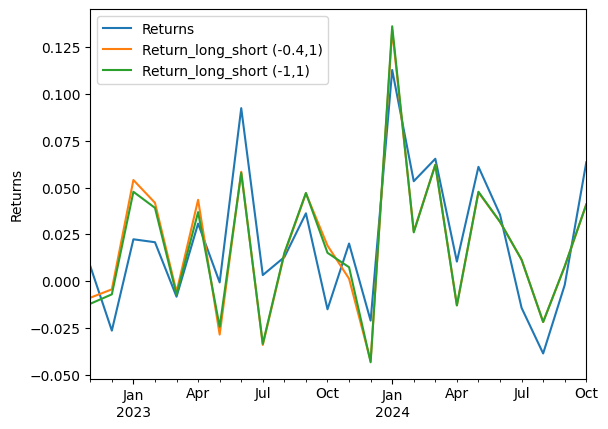

In [114]:
df_opt_monthlyend_returns_with_topix30_and_longshort['Returns'].plot(legend=True, ylabel='Returns')
# df_opt_monthlyend_returns_with_topix30_and_longshort['Return(TOPIX30)'].plot(legend=True)
df_opt_monthlyend_returns_with_topix30_and_longshort['Return_long_short (-0.4,1)'].plot(legend=True, ylabel='Returns')
df_opt_monthlyend_returns_with_topix30_and_longshort['Return_long_short (-1,1)'].plot(legend=True, ylabel='Returns')

<Axes: >

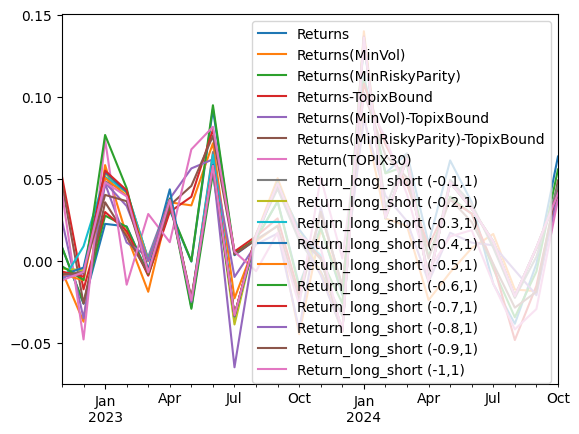

In [115]:
df_opt_monthlyend_returns_with_topix30_and_longshort.plot()

In [116]:
def calculate_rsi(data, window=14):
    delta1 = data["1311.T Price"].diff()
    # delta1 = delta.dropna()
    gain = (delta1.where(delta1 > 0, 0)).rolling(window=window).mean()
    loss = (-delta1.where(delta1 < 0, 0)).rolling(window=window).mean()
    rs = gain / loss.replace(0, np.nan)
    #print(rs)
    rsi = 100 - (100 / (1 + rs))
    print(type(rsi))
    print(len(rsi))
    return rsi

In [117]:
data = calculate_rsi(actual_prices)
bull_market_rsi = data > 70

<class 'pandas.core.series.Series'>
48


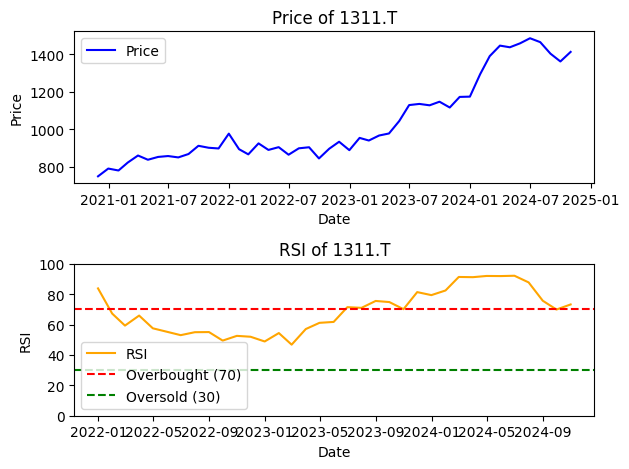

In [118]:
# Plot price data
plt.subplot(2, 1, 1)
plt.plot(actual_prices['Date'], actual_prices["1311.T Price"], label='Price', color='blue')
plt.title('Price of 1311.T')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot RSI data
plt.subplot(2, 1, 2)
plt.plot(actual_prices['Date'], data, label='RSI', color='orange')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('RSI of 1311.T')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.ylim(0, 100)  # RSI values range from 0 to 100

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [119]:
'''
opt_rets_long_short=[]
for i_date, date in enumerate(analysis_months):
  # Slice the returns data up to the current date
  historical_returns = monthly_returns.loc[:date]
  # Calculate the covariance matrix for the historical returns
  cov_matrix = historical_returns.cov()
  # Calculate expected returns by annualizing the historical returns
  expected_returns = annualize_rets(historical_returns)
  # print(expected_returns)
  bound = (-1,1)
  w_vol_long_short = minimize_vol_long_short_without_target(expected_returns, cov_matrix,bound) # default gross_exposure_limit = 2.0
  w_msr_long_short = msr_long_short(risk_free_rate, expected_returns, cov_matrix,bound)
  if i_date + 1 == len(analysis_months):
    break
  next_date = analysis_months[i_date+1]
  if next_date in monthly_returns.index:
    opt_ret_long_short = portfolio_return(w_msr_long_short, monthly_returns.loc[next_date])
    opt_rets_long_short.append(opt_ret_long_short)
  '''

'\nopt_rets_long_short=[]\nfor i_date, date in enumerate(analysis_months):\n  # Slice the returns data up to the current date\n  historical_returns = monthly_returns.loc[:date]\n  # Calculate the covariance matrix for the historical returns\n  cov_matrix = historical_returns.cov()\n  # Calculate expected returns by annualizing the historical returns\n  expected_returns = annualize_rets(historical_returns)\n  # print(expected_returns)\n  bound = (-1,1)\n  w_vol_long_short = minimize_vol_long_short_without_target(expected_returns, cov_matrix,bound) # default gross_exposure_limit = 2.0\n  w_msr_long_short = msr_long_short(risk_free_rate, expected_returns, cov_matrix,bound)\n  if i_date + 1 == len(analysis_months):\n    break\n  next_date = analysis_months[i_date+1]\n  if next_date in monthly_returns.index:\n    opt_ret_long_short = portfolio_return(w_msr_long_short, monthly_returns.loc[next_date])\n    opt_rets_long_short.append(opt_ret_long_short)\n  '